## FD viscoacoustic wavefield modeling for the fifth-order power-law Q dissipative model

###### Qi Hao, Aug. 20, 2021

References: \
[1] Hao, Q., and S. Greenhalgh, 2021, The viscoacoustic wave equations for frequency power law Q, Proceedings of the Royal Society A, submitted. \
[2] Hao, Q., and S. Greenhalgh, 2021, Nearly constant Q models of the generalized standard linear solid type and the corresponding wave equations, Geophysics, ８６（４）， T239-T260. 
[3] Hao, Q., and S. Greenhalgh, 2019, The generalized standard-linear-solid model and the corresponding viscoacoustic wave equations revisited, Geophysical Journal International, 219(3), 1939-1947. \
[4] Chu, C., and P. L. Stoffa, 2012, Determination of finite-difference weights using scaled binomial windows: Geophysics, 77(3), W17-W26. \
[5] Drossaert, F. H., and A. Giannopoulos, 2007, A nonsplit complex frequency-shifted PML based on recursive integration for FDTD modeling of elastic waves: Geophysics, 72(2), T9-T17.

In [1]:
# Import Libraries 
# ----------------
import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from pylab import rcParams
# from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
## Import my py_plot functions in file: pltfuns.py
from plt2dfuns import *

In [3]:
# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

import time as tm

import os

In [4]:
### folder name for the output figs
if not os.path.exists('./figs'):
    os.makedirs('./figs')

if not os.path.exists('./out'):
    os.makedirs('./out')

In [5]:
### ricker wavelet function
### -------------------------------------
def ricker_wavelet(fm, t):
    t0 = 1. / fm
    
    tmp = np.pi**2 * fm**2 * (t-t0)**2
    
    ft = (1. - 2. * tmp) * np.exp(-tmp)
    
    tmp0 = np.pi**2 * fm**2 * (0.-t0)**2
    ft0  = (1. - 2. * tmp0) * np.exp(-tmp0)
    
    ft = ft - ft0
    
    return ft
### -------------------------------------

### calculate the PML coefficient arrays
###---------------------------------------
def get_pml_coeffs(kappa_max, sigma_max, alpha_max, n_absorb, nz, nx):
    """ attenuation coefficient for the model with absorbing layers """
    kappa_x_hlf = np.zeros((nz, nx))
    kappa_z_hlf = np.zeros((nz, nx))
    
    sigma_x_hlf = np.zeros((nz, nx))    
    sigma_z_hlf = np.zeros((nz, nx))
    
    alpha_x_hlf = np.zeros((nz, nx))   
    alpha_z_hlf = np.zeros((nz, nx))
    
    kappa_x = np.zeros((nz, nx))
    kappa_z = np.zeros((nz, nx))    
    
    sigma_x = np.zeros((nz, nx))
    sigma_z = np.zeros((nz, nx))
    
    alpha_x = np.zeros((nz, nx))   
    alpha_z = np.zeros((nz, nx))    
    
    n_pml = n_absorb - 1
    
    ### PML layer for the staggered grids along z   
    for iz in range(nz):
        id4z = iz + 0.5
        ### the left PML layer
        if id4z <= n_pml:            
            dist = n_pml - id4z
            kappa_z_hlf[iz, :] = kappa_max * (dist/n_pml)**2 + 1
            sigma_z_hlf[iz, :] = sigma_max * (dist/n_pml)**2
            ##alpha_z_hlf[iz, :] = alpha_max * (dist/n_pml)**2
            alpha_z_hlf[iz, :] = alpha_max * abs(1 - (dist/n_pml))
        ### the right PML layer            
        elif id4z >= (nz-1-n_pml):
            dist = id4z - (nz-1-n_pml)
            kappa_z_hlf[iz, :] = kappa_max * (dist/n_pml)**2 + 1
            sigma_z_hlf[iz, :] = sigma_max * (dist/n_pml)**2 
            ##alpha_z_hlf[iz, :] = alpha_max * (dist/n_pml)**2
            alpha_z_hlf[iz, :] = alpha_max * abs(1 - (dist/n_pml))
        else:
            kappa_z_hlf[iz, :] = 1

    ### PML layer for the staggered grids along x   
    for ix in range(nx):
        id4x = ix + 0.5        
        ### the left PML layer
        if id4x <= n_pml:
            dist = n_pml - id4x
            kappa_x_hlf[:, ix] = kappa_max * (dist/n_pml)**2 + 1
            sigma_x_hlf[:, ix] = sigma_max * (dist/n_pml)**2
            ##alpha_x_hlf[:, ix] = alpha_max * (dist/n_pml)**2
            alpha_x_hlf[:, ix] = alpha_max * abs(1 - (dist/n_pml))
        ### the right PML layer            
        elif id4x >= (nx-1-n_pml):
            dist = id4x - (nx-1-n_pml)
            kappa_x_hlf[:, ix] = kappa_max * (dist/n_pml)**2 + 1
            sigma_x_hlf[:, ix] = sigma_max * (dist/n_pml)**2 
            ##alpha_x_hlf[:, ix] = alpha_max * (dist/n_pml)**2
            alpha_x_hlf[:, ix] = alpha_max * abs(1 - (dist/n_pml))
        else:
            kappa_x_hlf[:, ix] = 1          
            
    ### PML layer for the regular grids along z
    for iz in range(nz):
        ### the left PML layer
        if iz <= n_pml:
            dist = n_pml - iz
            kappa_z[iz, :] = kappa_max * (dist/n_pml)**2 + 1
            sigma_z[iz, :] = sigma_max * (dist/n_pml)**2
            ##alpha_z[iz, :] = alpha_max * (dist/n_pml)**2
            alpha_z[iz, :] = alpha_max * abs(1 - (dist/n_pml))
        ### the right PML layer
        elif iz >= (nz-1-n_pml):
            dist = iz - (nz-1-n_pml)
            kappa_z[iz, :] = kappa_max * (dist/n_pml)**2 + 1
            sigma_z[iz, :] = sigma_max * (dist/n_pml)**2
            ##alpha_z[iz, :] = alpha_max * (dist/n_pml)**2
            alpha_z[iz, :] = alpha_max * abs(1 - (dist/n_pml))
        else:
            kappa_z[iz, :] = 1
            
    ### PML layer for the regular grids along x
    for ix in range(nx):
        ### the left PML layer
        if ix <= n_pml:
            dist = n_pml - ix
            kappa_x[:, ix] = kappa_max * (dist/n_pml)**2 + 1 
            sigma_x[:, ix] = sigma_max * (dist/n_pml)**2
            ##alpha_x[:, ix] = alpha_max * (dist/n_pml)**2
            alpha_x[:, ix] = alpha_max * abs(1- (dist/n_pml))
        ### the right PML layer
        elif ix >= (nx-1-n_pml):
            dist = ix - (nx-1-n_pml)
            kappa_x[:, ix] = kappa_max * (dist/n_pml)**2 + 1
            sigma_x[:, ix] = sigma_max * (dist/n_pml)**2 
            ##alpha_x[:, ix] = alpha_max * (dist/n_pml)**2
            alpha_x[:, ix] = alpha_max * abs(1 - (dist/n_pml))
        else:
            kappa_x[:, ix] = 1
    
    
    return kappa_z_hlf, kappa_x_hlf, sigma_z_hlf, sigma_x_hlf, alpha_z_hlf, alpha_x_hlf, \
           kappa_z, kappa_x, sigma_z, sigma_x, alpha_z, alpha_x


def get_pml_coeff_arrays(kappa_max, sigma_max, alpha_max, dt, n_absorb, nz, nx):
    """ attenuation coefficient for the model with absorbing layers """
    kappa_x_hlf = np.zeros((nz, nx))
    kappa_z_hlf = np.zeros((nz, nx))
    
    sigma_x_hlf = np.zeros((nz, nx))    
    sigma_z_hlf = np.zeros((nz, nx))
    
    alpha_x_hlf = np.zeros((nz, nx))   
    alpha_z_hlf = np.zeros((nz, nx))
    
    kappa_x = np.zeros((nz, nx))
    kappa_z = np.zeros((nz, nx))    
    
    sigma_x = np.zeros((nz, nx))
    sigma_z = np.zeros((nz, nx))
    
    alpha_x = np.zeros((nz, nx))   
    alpha_z = np.zeros((nz, nx))    
    
    n_pml = n_absorb - 1
    
    ### PML layer for the staggered grids along z   
    for iz in range(nz):
        id4z = iz + 0.5
        ### the left PML layer
        if id4z <= n_pml:            
            dist = n_pml - id4z
            kappa_z_hlf[iz, :] = kappa_max * (dist/n_pml)**2 + 1
            sigma_z_hlf[iz, :] = sigma_max * (dist/n_pml)**2
            ##alpha_z_hlf[iz, :] = alpha_max * (dist/n_pml)**2
            alpha_z_hlf[iz, :] = alpha_max * abs(1 - (dist/n_pml))**2
        ### the right PML layer            
        elif id4z >= (nz-1-n_pml):
            dist = id4z - (nz-1-n_pml)
            kappa_z_hlf[iz, :] = kappa_max * (dist/n_pml)**2 + 1
            sigma_z_hlf[iz, :] = sigma_max * (dist/n_pml)**2 
            ##alpha_z_hlf[iz, :] = alpha_max * (dist/n_pml)**2
            alpha_z_hlf[iz, :] = alpha_max * abs(1 - (dist/n_pml))**2
        else:
            kappa_z_hlf[iz, :] = 1

    ### PML layer for the staggered grids along x   
    for ix in range(nx):
        id4x = ix + 0.5        
        ### the left PML layer
        if id4x <= n_pml:
            dist = n_pml - id4x
            kappa_x_hlf[:, ix] = kappa_max * (dist/n_pml)**2 + 1
            sigma_x_hlf[:, ix] = sigma_max * (dist/n_pml)**2
            ##alpha_x_hlf[:, ix] = alpha_max * (dist/n_pml)**2
            alpha_x_hlf[:, ix] = alpha_max * abs(1 - (dist/n_pml))**2
        ### the right PML layer            
        elif id4x >= (nx-1-n_pml):
            dist = id4x - (nx-1-n_pml)
            kappa_x_hlf[:, ix] = kappa_max * (dist/n_pml)**2 + 1
            sigma_x_hlf[:, ix] = sigma_max * (dist/n_pml)**2 
            ##alpha_x_hlf[:, ix] = alpha_max * (dist/n_pml)**2
            alpha_x_hlf[:, ix] = alpha_max * abs(1 - (dist/n_pml))**2
        else:
            kappa_x_hlf[:, ix] = 1          
            
    ### PML layer for the regular grids along z
    for iz in range(nz):
        ### the left PML layer
        if iz <= n_pml:
            dist = n_pml - iz
            kappa_z[iz, :] = kappa_max * (dist/n_pml)**2 + 1
            sigma_z[iz, :] = sigma_max * (dist/n_pml)**2
            ##alpha_z[iz, :] = alpha_max * (dist/n_pml)**2
            alpha_z[iz, :] = alpha_max * abs(1 - (dist/n_pml))**2
        ### the right PML layer
        elif iz >= (nz-1-n_pml):
            dist = iz - (nz-1-n_pml)
            kappa_z[iz, :] = kappa_max * (dist/n_pml)**2 + 1
            sigma_z[iz, :] = sigma_max * (dist/n_pml)**2
            ##alpha_z[iz, :] = alpha_max * (dist/n_pml)**2
            alpha_z[iz, :] = alpha_max * abs(1 - (dist/n_pml))**2
        else:
            kappa_z[iz, :] = 1
            
    ### PML layer for the regular grids along x
    for ix in range(nx):
        ### the left PML layer
        if ix <= n_pml:
            dist = n_pml - ix
            kappa_x[:, ix] = kappa_max * (dist/n_pml)**2 + 1 
            sigma_x[:, ix] = sigma_max * (dist/n_pml)**2
            ##alpha_x[:, ix] = alpha_max * (dist/n_pml)**2
            alpha_x[:, ix] = alpha_max * abs(1- (dist/n_pml))**2
        ### the right PML layer
        elif ix >= (nx-1-n_pml):
            dist = ix - (nx-1-n_pml)
            kappa_x[:, ix] = kappa_max * (dist/n_pml)**2 + 1
            sigma_x[:, ix] = sigma_max * (dist/n_pml)**2 
            ##alpha_x[:, ix] = alpha_max * (dist/n_pml)**2
            alpha_x[:, ix] = alpha_max * abs(1 - (dist/n_pml))**2
        else:
            kappa_x[:, ix] = 1

    ### get the coefficients for applying the PML to dpdx, dpdz, and dpdxx, dpdzz 
    ### ---------------------------------------------------------------------------
    xi_z_hlf  = (1. + 0.5*dt*alpha_z_hlf) / (kappa_z_hlf + 0.5*dt*(sigma_z_hlf + alpha_z_hlf*kappa_z_hlf))
    xi_x_hlf  = (1. + 0.5*dt*alpha_x_hlf) / (kappa_x_hlf + 0.5*dt*(sigma_x_hlf + alpha_x_hlf*kappa_x_hlf))

    phi_z_hlf = dt / (kappa_z_hlf + 0.5*dt*(sigma_z_hlf + alpha_z_hlf*kappa_z_hlf))
    phi_x_hlf = dt / (kappa_x_hlf + 0.5*dt*(sigma_x_hlf + alpha_x_hlf*kappa_x_hlf))

    lambda_z_hlf = sigma_z_hlf + alpha_z_hlf*kappa_z_hlf
    lambda_x_hlf = sigma_x_hlf + alpha_x_hlf*kappa_x_hlf

    xi_z  = (1. + 0.5*dt*alpha_z) / (kappa_z + 0.5*dt*(sigma_z + alpha_z*kappa_z))
    xi_x  = (1. + 0.5*dt*alpha_x) / (kappa_x + 0.5*dt*(sigma_x + alpha_x*kappa_x))

    phi_z = dt / (kappa_z + 0.5*dt*(sigma_z + alpha_z*kappa_z))
    phi_x = dt / (kappa_x + 0.5*dt*(sigma_x + alpha_x*kappa_x))

    lambda_z = sigma_z + alpha_z*kappa_z
    lambda_x = sigma_x + alpha_x*kappa_x

    ### delete useless arrays
    del kappa_x_hlf
    del kappa_z_hlf    
    del sigma_x_hlf    
    del sigma_z_hlf        
    del kappa_x
    del kappa_z        
    del sigma_x
    del sigma_z              
    
    
    return xi_z_hlf, xi_x_hlf, phi_z_hlf, phi_x_hlf, lambda_z_hlf, lambda_x_hlf, alpha_z_hlf, alpha_x_hlf, \
           xi_z,     xi_x,     phi_z,     phi_x,     lambda_z,     lambda_x,     alpha_z,     alpha_x


In [6]:
################ Read model velocity and 1/Q files ###########################
nx_model = 737
nz_model = 320

v0_array  = np.load("./model_out/v0_model.npy")
iQ0_array = np.load("./model_out/iQ0_model.npy")
gam_array = np.load("./model_out/gamma_model.npy")

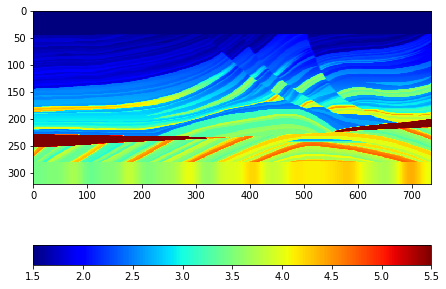

maximum velocity is 5.5
minimum velocity is 1.4999999999999996


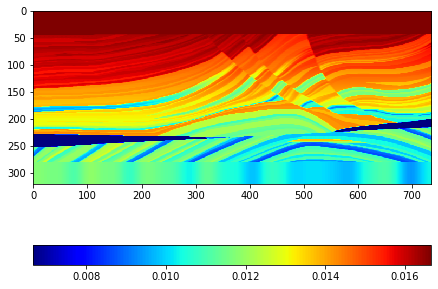

maximum iQ is 0.016666666666666666
minimum iQ is 0.006666666666666668


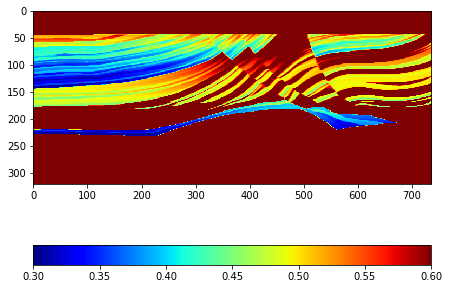

maximum gamma is 0.6000000000000002
minimum gamma is 0.3


In [7]:
### check the input model before modeling
## plot the Marmousi model
plot_check_model(v0_array, nz_model, nx_model)
print("maximum velocity is " + str(np.max(v0_array)))
print("minimum velocity is " + str(np.min(v0_array)))

## plot the Marmousi model
plot_check_model(iQ0_array, nz_model, nx_model)
print("maximum iQ is " + str(np.max(iQ0_array)))
print("minimum iQ is " + str(np.min(iQ0_array)))

## plot the Marmousi model
plot_check_model(gam_array, nz_model, nx_model)
print("maximum gamma is " + str(np.max(gam_array)))
print("minimum gamma is " + str(np.min(gam_array)))

In [8]:
# Definition of modelling parameters
# ----------------------------------
nx = nx_model
nz = nz_model

dx   = 50 * 0.005     # grid point distance in x-direction
dz   = dx        # grid point distance in z-direction

xmax = (nx-1) * dx   # maximum spatial extension of the 2D model in x-direction (km)
zmax = (nz-1) * dz   # maximum spatial extension of the 2D model in z-direction(km)

tmax = 50 * 2.0         # maximum recording time of the seismogram (s)

dt   = 50 * 0.1E-3    # time step

nt = (int)(tmax/dt) # maximum number of time steps            
print('nt = ',nt)

###------------------------------
### time parameters in the seismogram
dt_fout = 50 * 1.0E-3

it_fout = int(dt_fout / dt)

if it_fout < 1:
    it_fout = 1
    
dt_fout = dt * it_fout
nt_fout = int((nt-1)/it_fout) + 1

nt =  20000


In [9]:
### attenuation control parameter
iQflag = 1       # 0 or 1 the flag for attenuation (inverse of quality factor)
###------------------------------------------------
###------------------------------------------------
iQ0_array = iQ0_array * iQflag

In [10]:
### snapshot print parameter
it_snapshot = 100   # Increment to plot snapshots

In [11]:
## source infor: Ricker wavelet 
## -------------------------------
f0   = 1      # dominant frequency of the source (Hz)

## point-source position------------
xsrc = xmax / 2      # x-coordinate of source (km)
zsrc = 225*dz        # z-coordinate of source (km)

In [12]:
### A array of receivers at the horizontal plane zr = zsrc
### ---------------------------
zr = 40*dz            # receiver and source are at the same horizontal line

In [13]:
### Determination of the grid coordinates 
### --------------------------------------------             
jr = (int)(zr/dz+0.5)      # receiver location in grid in z-direction
    
isrc = (int)(xsrc/dx+0.5)  # source location in grid in x-direction
jsrc = (int)(zsrc/dz+0.5)  # source location in grid in z-direction

print("jr=", jr)
print("(isrc,jsrc)",isrc,jsrc)

jr= 40
(isrc,jsrc) 368 225


In [14]:
# generating the array of the source wavelet: Ricker
# -------------------------------
src  = np.zeros(nt)
time = np.linspace(0 * dt, nt * dt, nt)

nt_period = int(1./f0 / dt)

src[0:2*nt_period] = ricker_wavelet(f0, time[0:2*nt_period])

In [15]:
###----------------------------------------------------------------------
###  The number of PML layers is determined by the main frequency
###--------------------------------------------------------------------- 
vPMLmax = 5.0  ###this velocity is obtained by testing PML in the marmousi model
f0ref = f0 ### reference frequency for PML 
# n_absorb   = int(vmax/f0ref/np.min([dx,dz]))        # Width of absorbing edges
n_absorb = 40
print('The number of PML layers are: n_absorb=', n_absorb)  

The number of PML layers are: n_absorb= 40


In [16]:
### Nonsplit PML parameters: kappa, alpha 
### --------------------------------------
kappa_max = 0.5
alpha_max = 1.

### Maximum reflection coeffs at the PML layer
Rcmax = 1.E-6

In [17]:
######### Homogeneous PML layer #############################################
### Nonsplit PML parameters: sigma, obtained from the following formula
### ---------------------------------
### maximum unrelaxed velocity 
# vpUmax = np.max(vp_array * np.sqrt(1. + iQ_array))
# vpUmax = np.max(vp_array)

### sigma is the dominant parameters to control the PML
sigma_x_max = -3/2 * vPMLmax / ((n_absorb-1)*dx) * np.log10(Rcmax) 
sigma_z_max = -3/2 * vPMLmax / ((n_absorb-1)*dz) * np.log10(Rcmax)
sigma_max = max(sigma_x_max, sigma_z_max) * 4

### print sigma
print('vpUmax =', vPMLmax)
print('sigma_max =', sigma_max)

########################################################################
### Get PML parameters arrays for the whole model 
### ----------------------------------------
# kappa_z_hlf, kappa_x_hlf, \
# sigma_z_hlf, sigma_x_hlf, \
# alpha_z_hlf, alpha_x_hlf, \
# kappa_z, kappa_x,         \
# sigma_z, sigma_x,         \
# alpha_z, alpha_x          \
# = get_pml_coeffs(kappa_max, sigma_max, alpha_max, n_absorb, nz, nx)

vpUmax = 5.0
sigma_max = 18.461538461538463


In [18]:
########################################################################
### Get PML parameters arrays for the whole model 
### ----------------------------------------
xi_z_hlf,     xi_x_hlf,     \
phi_z_hlf,    phi_x_hlf,    \
lambda_z_hlf, lambda_x_hlf, \
alpha_z_hlf,  alpha_x_hlf,  \
xi_z,         xi_x,         \
phi_z,        phi_x,        \
lambda_z,     lambda_x,     \
alpha_z,      alpha_x       \
= get_pml_coeff_arrays(kappa_max, sigma_max, alpha_max, dt, n_absorb, nz, nx)

In [19]:
### The PML version of dpdx, dpdz, dpdxx, dpdzz
### S_x -> dpdx, S_z -> dpdz, S_xx -> dpdxx, S_zz -> dpdzz
### Omega_x, Omega_z are auxiliary variables, used to update S_x and S_z.
### Omega_xx, Omega_zz are auxiliary variables, used to update S_xx and S_zz.
### See eqs. 18 and 19 in Drossaert and Giannopoulos (2007).
### ---------------------------------------------------------------------------
S_x = np.zeros((nz, nx))
S_z = np.zeros((nz, nx))

Omega_x = np.zeros((nz, nx))
Omega_z = np.zeros((nz, nx))

S_xx = np.zeros((nz, nx))
S_zz = np.zeros((nz, nx))

Omega_xx = np.zeros((nz, nx))
Omega_zz = np.zeros((nz, nx))

In [20]:
# Create and initialize pressure and its derivative arrays
# ---------------------------------------
p    = np.zeros((nz,nx)) # p at time n (now)
pold = np.zeros((nz,nx)) # p at time n-1 (past)
pnew = np.zeros((nz,nx)) # p at time n+1 (present)

dpx  = np.zeros((nz,nx)) # 1st spatial x-derivative of p
dpz  = np.zeros((nz,nx)) # 1st spatial z-derivative of p

d2px = np.zeros((nz,nx)) # 2nd spatial x-derivative of p
d2pz = np.zeros((nz,nx)) # 2nd spatial z-derivative of p
# ---------------------------------------

## Create and initialize auxiliary variables r_{ij}, i denotes the order index, j denotes the element index.
## i = a, b, c, d, e, which are the 1st, 2nd, 3rd, 4th and 5th orders, respectively.
## j = 0, 1, 2, 3, 4, which are the element index. 
## ---1st order------------------------------------
ra0_old = np.zeros((nz,nx))
ra1_old = np.zeros((nz,nx))
ra2_old = np.zeros((nz,nx))
ra3_old = np.zeros((nz,nx))
ra4_old = np.zeros((nz,nx))

ra0_new = np.zeros((nz,nx))
ra1_new = np.zeros((nz,nx))
ra2_new = np.zeros((nz,nx))
ra3_new = np.zeros((nz,nx))
ra4_new = np.zeros((nz,nx))

## ---2nd order------------------------------------
rb0_old = np.zeros((nz,nx))
rb1_old = np.zeros((nz,nx))
rb2_old = np.zeros((nz,nx))
rb3_old = np.zeros((nz,nx))
rb4_old = np.zeros((nz,nx))

rb0_new = np.zeros((nz,nx))
rb1_new = np.zeros((nz,nx))
rb2_new = np.zeros((nz,nx))
rb3_new = np.zeros((nz,nx))
rb4_new = np.zeros((nz,nx))

## ---3rd order------------------------------------
rc0_old = np.zeros((nz,nx))
rc1_old = np.zeros((nz,nx))
rc2_old = np.zeros((nz,nx))
rc3_old = np.zeros((nz,nx))
rc4_old = np.zeros((nz,nx))

rc0_new = np.zeros((nz,nx))
rc1_new = np.zeros((nz,nx))
rc2_new = np.zeros((nz,nx))
rc3_new = np.zeros((nz,nx))
rc4_new = np.zeros((nz,nx))

## ---4th order------------------------------------
rd0_old = np.zeros((nz,nx))
rd1_old = np.zeros((nz,nx))
rd2_old = np.zeros((nz,nx))
rd3_old = np.zeros((nz,nx))
rd4_old = np.zeros((nz,nx))

rd0_new = np.zeros((nz,nx))
rd1_new = np.zeros((nz,nx))
rd2_new = np.zeros((nz,nx))
rd3_new = np.zeros((nz,nx))
rd4_new = np.zeros((nz,nx))

## ---5th order------------------------------------
re0_old = np.zeros((nz,nx))
re1_old = np.zeros((nz,nx))
re2_old = np.zeros((nz,nx))
re3_old = np.zeros((nz,nx))
re4_old = np.zeros((nz,nx))

re0_new = np.zeros((nz,nx))
re1_new = np.zeros((nz,nx))
re2_new = np.zeros((nz,nx))
re3_new = np.zeros((nz,nx))
re4_new = np.zeros((nz,nx))

In [21]:
### tau_sigma, tau_epsilon in the weight-function for the constant-Q.
### AlphaBeta are from Table 11 of HG2021 in Geophysics. 
AlphaBelta =                              \
np.array([[1.8230838e-01, 2.7518001e-01], \
          [3.2947348e-02, 3.0329269e-02], \
          [8.4325390e-03, 6.9820198e-03], \
          [2.3560480e-03, 1.9223614e-03], \
          [5.1033826e-04, 7.2390630e-04]])

factor = 1/50   ### fc=1 Hz

### frequency range factor*[1, 200]
tau_sigma   =  AlphaBelta[:,0] / factor
tau_epsilon = (AlphaBelta[:,0] + AlphaBelta[:,1]) / factor

In [22]:
### vU2 and sl arrays in the wave equations
### -----------------------------------
omega0 = 2*np.pi*f0

### g
g = np.sum((tau_epsilon/tau_sigma - 1.)/(1. + omega0*omega0*tau_sigma*tau_sigma)) 

### compute the coefficients a_{n} for the 5th-order series of the modulus. 
### The Math-to-Py expressions for a_{n} in the folder "math/models_math/Gen_method_for_an/Math2Python", 
### are directly copied here.  
iQ0  = np.copy(iQ0_array) 
beta = np.copy(gam_array * np.pi)

### den
aux0=(6.*(beta*((-15072.+((-1532.*(beta**2))+(9.*(beta**4.))))*(\
iQ0**3.))))+(24.*((1464.+((348.*(beta**2))+(5.*(beta**4.))))*(iQ0**4.)\
));
aux1=((103680.+((67248.*(beta**2))+((72.*(beta**4.))+(beta**6.))))*(\
iQ0**2))+aux0;
den=69120.+((-24.*(beta*((5040.+(47.*(beta**2)))*iQ0)))+aux1);

### a1
aux0=(144.*((beta**2)*(20.+(437.*(iQ0**2)))))+(2880.*(24.+((28.*(\
iQ0**2))+(5.*(iQ0**4.)))));
aux1=(-1728.*(beta*(iQ0*(70.+(29.*(iQ0**2))))))+((-24.*((beta**3.)*(\
iQ0*(257.+(101.*(iQ0**2))))))+aux0);
output1=(54.*((beta**5.)*iQ0))+(((beta**6.)*(iQ0**2))+((-12.*((beta**4.\
)*(-7.+(iQ0**2))))+aux1));

a1 = output1 / den

### a2
aux0=(6.*(beta*((-5760.+((-788.*(beta**2))+(7.*(beta**4.))))*(iQ0**2))\
))+(72.*((200.+((68.*(beta**2))+(beta**4.)))*(iQ0**3.)));
aux1=((17280.+((16560.*(beta**2))+((192.*(beta**4.))+(beta**6.))))*\
iQ0)+aux0;
output2=2.*((-360.*(beta*(24.+(beta**2))))+aux1);

a2 = output2 / den

### a3
aux0=(-72.*((beta**3.)*(iQ0*(45.+(7.*(iQ0**2))))))+(720.*((beta**2)*(\
2.+(19.*(iQ0**2)))));
aux1=(-2880.*(beta*(iQ0*(3.+(4.*(iQ0**2))))))+((12.*((beta**4.)*(5.+(\
7.*(iQ0**2)))))+aux0);
aux2=(42.*((beta**5.)*iQ0))+(((beta**6.)*(iQ0**2))+((2880.*((iQ0**2)*(\
2.+(iQ0**2))))+aux1));
output3=2.*aux2;

a3 = output3 / den

### a4
aux0=(30.*(beta*((-288.+((-60.*(beta**2))+(beta**4.)))*(iQ0**2))))+(\
24.*((120.+((60.*(beta**2))+(beta**4.)))*(iQ0**3.)));
output4=(-360.*(beta**3.))+(((beta**2)*((5040.+((120.*(beta**2))+(\
beta**4.)))*iQ0))+aux0);

a4 = output4 / den

### a5
aux0=((beta**2)*((3600.+((-12.*(beta**2))+(beta**4.)))*(iQ0**2)))+((-\
120.*(beta*((24.+(beta**2))*(iQ0**3.))))+(576.*(iQ0**4.)));
output5=(36.*(beta**4.))+((30.*((beta**3.)*((-36.+(beta**2))*iQ0)))+\
aux0);

a5 = output5 / den

del den, output1, output2, output3, output4, output5

#### compute bn, 0 <= n <= 5. 
b0 = a1*g + a2*g**2 + a3*g**3   + a4*g**4   + a5*g**5 
b1 = a1   + 2*a2*g  + 3*a3*g**2 + 4*a4*g**3 + 5*a5*g**4
b2 = a2   + 3*a3*g  + 6*a4*g**2 + 10*a5*g**3
b3 = a3   + 4*a4*g  + 10*a5*g**2
b4 = a4   + 5*a5*g
b5 = a5

#### compute An
vp2 = v0_array**2
vt2 = vp2 / (1 + iQ0*(-a2 + a4))

A0_array = vt2 * (1 + b0*iQ0)
Aa_array = vt2 * b1*iQ0
Ab_array = vt2 * b2*iQ0
Ac_array = vt2 * b3*iQ0
Ad_array = vt2 * b4*iQ0
Ae_array = vt2 * b5*iQ0

del a1, a2, a3, a4, a5
del b0, b1, b2, b3, b4, b5
del vp2, vt2

### Weights used in the FD discretization of the equations associated with the memory variables
### weight1_array and weight_array have 5 elements, respectively

sl = (tau_epsilon/tau_sigma - 1.) / tau_sigma

weight1 = (1 - 0.5*dt/tau_sigma) / (1 + 0.5*dt/tau_sigma) 
weight2 = 1. / (1 + 0.5*dt/tau_sigma)

In [23]:
# Create and initialize seismogram
# ---------------------------
seis_all = np.zeros((nt_fout, nx))  ## seismogram at all receivers at surface

In [24]:
### 14-th order central FD coeffs for 1st derivative on staggered grids
cn = np.zeros(7)
###---------------------------------------------
cn[0] =   1288287. / 1048576.
cn[1] =   -429429. / 4194304.   
cn[2] =    429429. / 20971520.
cn[3] =    -61347. / 14680064.
cn[4] =     13013. / 18874368.
cn[5] =     -3549. / 46137344.
cn[6] =       231. / 54525952.

it/nt = 0/20000


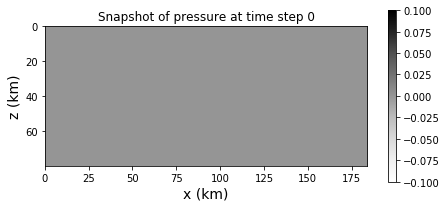

it/nt = 100/20000


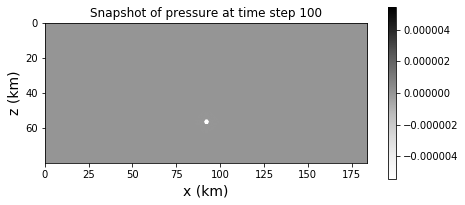

it/nt = 200/20000


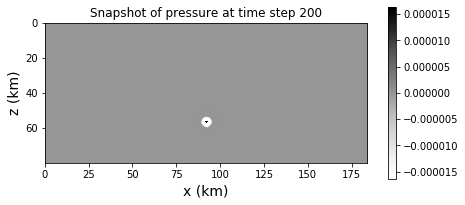

it/nt = 300/20000


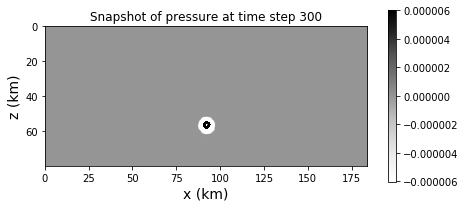

it/nt = 400/20000


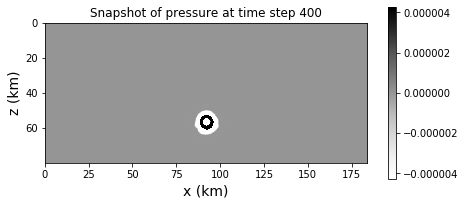

it/nt = 500/20000


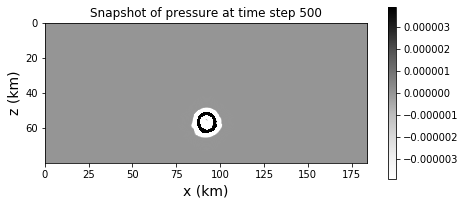

it/nt = 600/20000


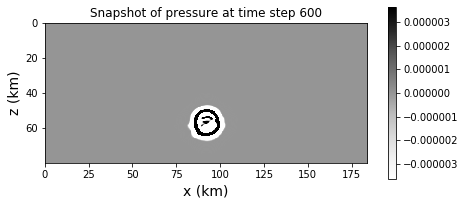

it/nt = 700/20000


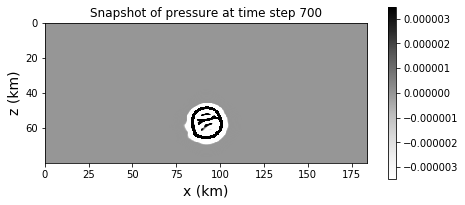

it/nt = 800/20000


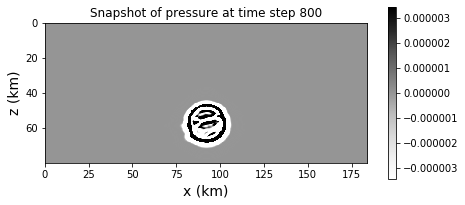

it/nt = 900/20000


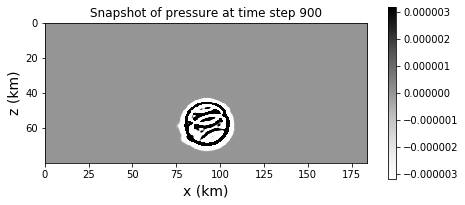

it/nt = 1000/20000


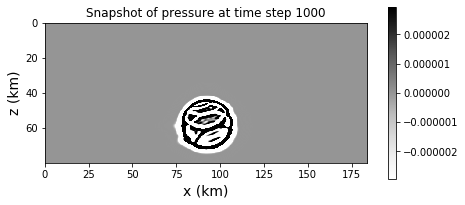

it/nt = 1100/20000


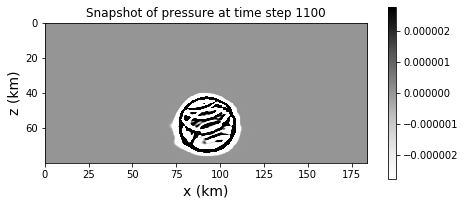

it/nt = 1200/20000


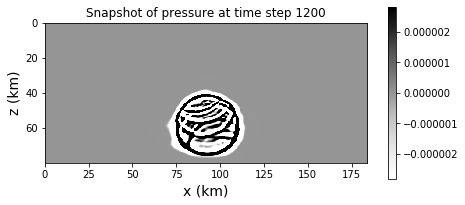

it/nt = 1300/20000


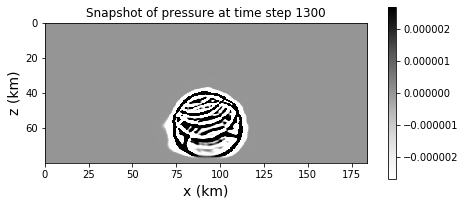

it/nt = 1400/20000


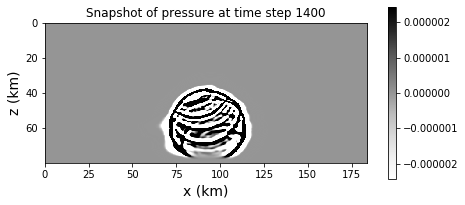

it/nt = 1500/20000


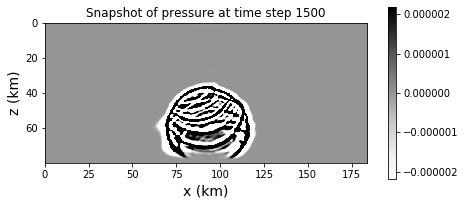

it/nt = 1600/20000


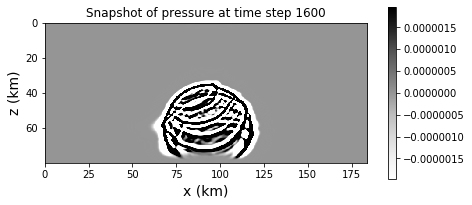

it/nt = 1700/20000


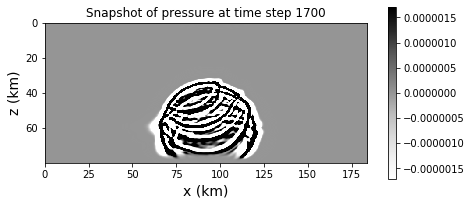

it/nt = 1800/20000


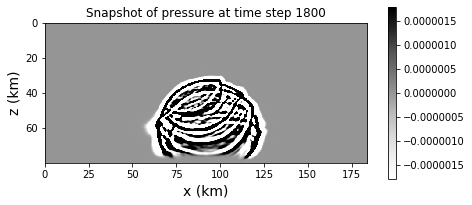

it/nt = 1900/20000


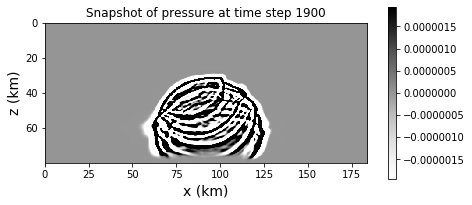

it/nt = 2000/20000


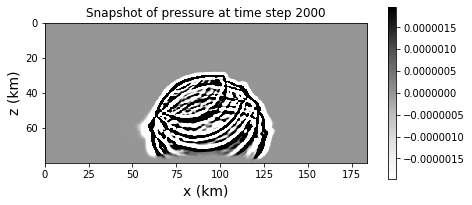

it/nt = 2100/20000


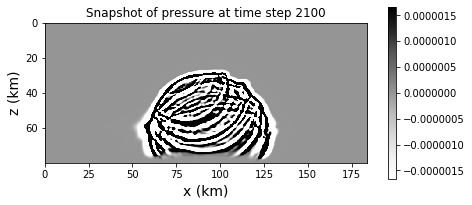

it/nt = 2200/20000


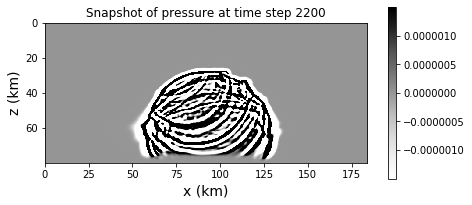

it/nt = 2300/20000


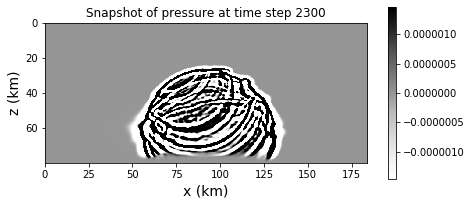

it/nt = 2400/20000


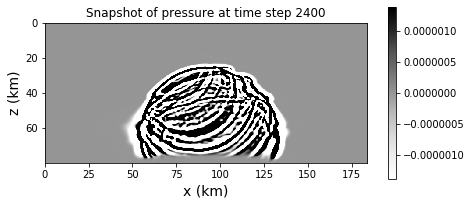

it/nt = 2500/20000


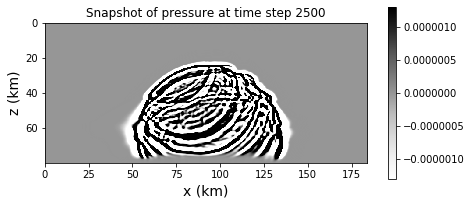

it/nt = 2600/20000


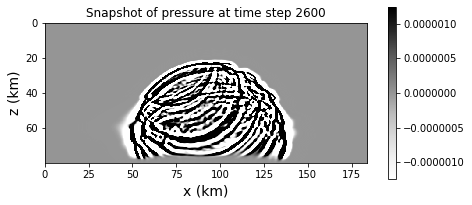

it/nt = 2700/20000


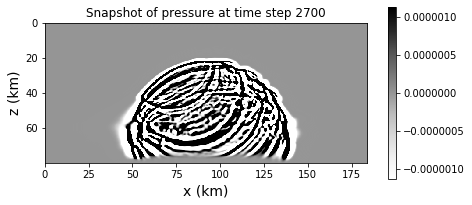

it/nt = 2800/20000


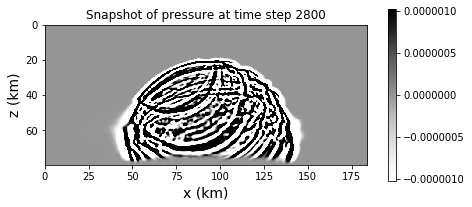

it/nt = 2900/20000


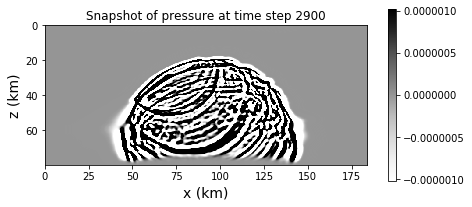

it/nt = 3000/20000


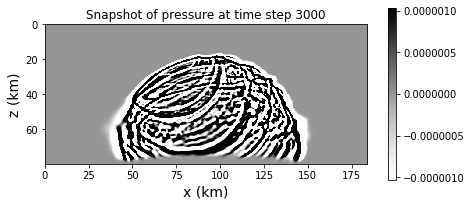

it/nt = 3100/20000


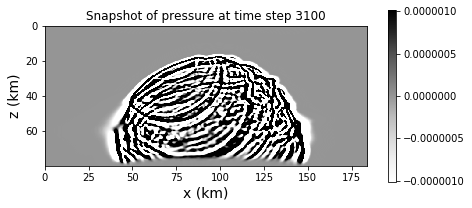

it/nt = 3200/20000


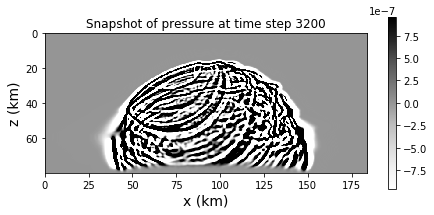

it/nt = 3300/20000


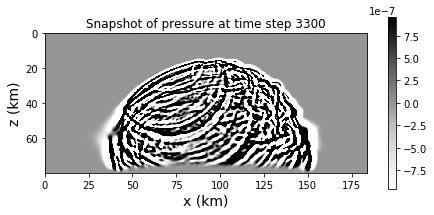

it/nt = 3400/20000


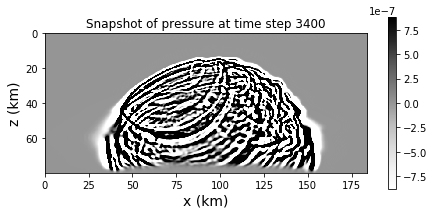

it/nt = 3500/20000


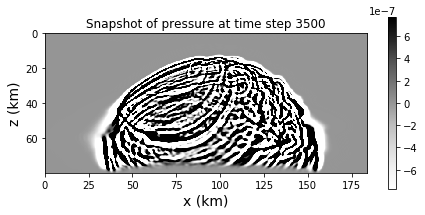

it/nt = 3600/20000


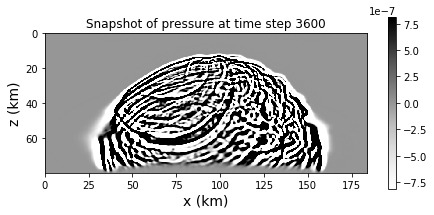

it/nt = 3700/20000


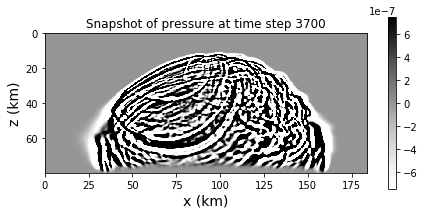

it/nt = 3800/20000


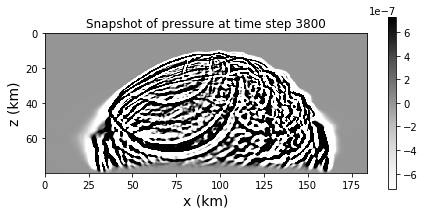

it/nt = 3900/20000


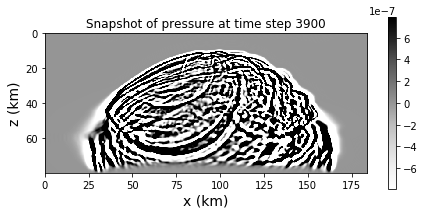

it/nt = 4000/20000


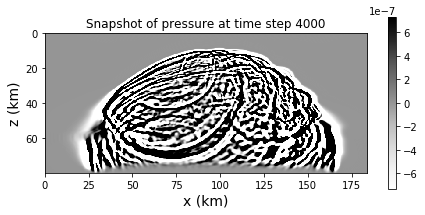

it/nt = 4100/20000


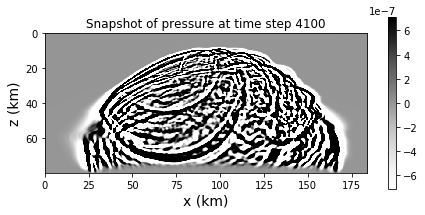

it/nt = 4200/20000


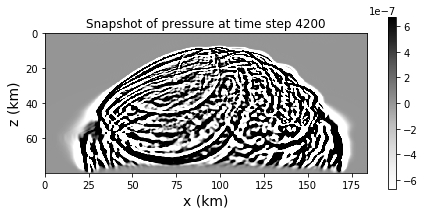

it/nt = 4300/20000


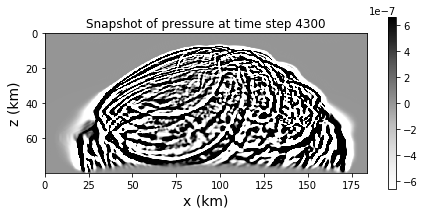

it/nt = 4400/20000


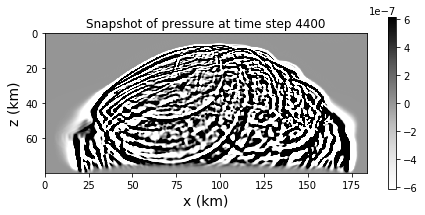

it/nt = 4500/20000


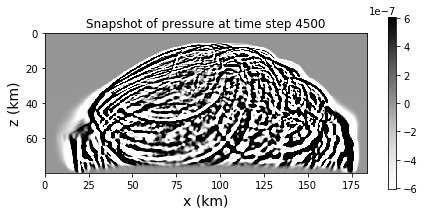

it/nt = 4600/20000


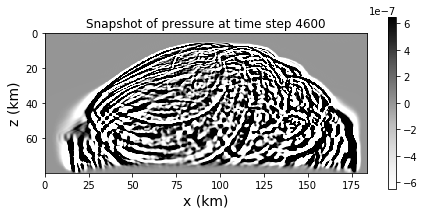

it/nt = 4700/20000


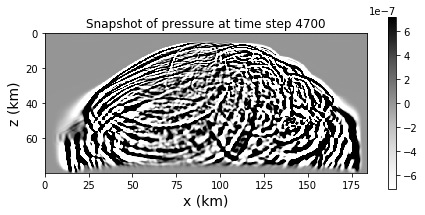

it/nt = 4800/20000


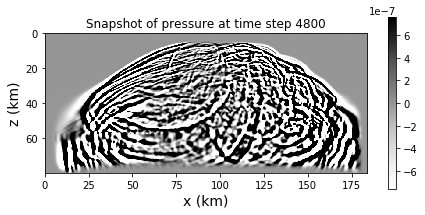

it/nt = 4900/20000


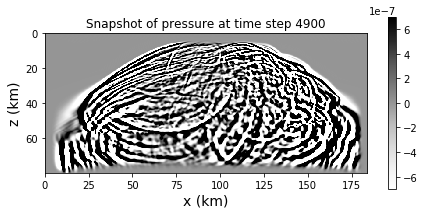

it/nt = 5000/20000


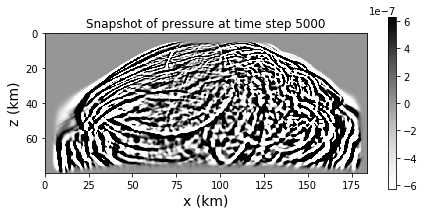

it/nt = 5100/20000


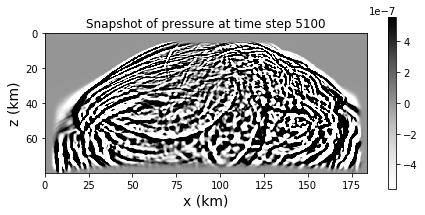

it/nt = 5200/20000


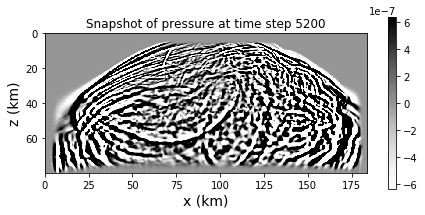

it/nt = 5300/20000


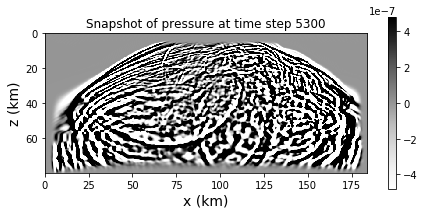

it/nt = 5400/20000


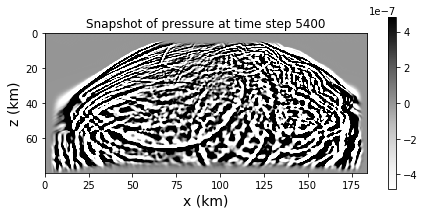

it/nt = 5500/20000


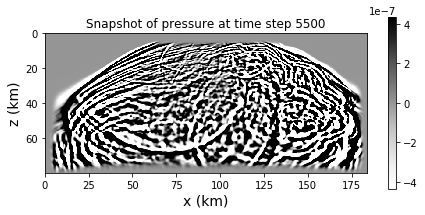

it/nt = 5600/20000


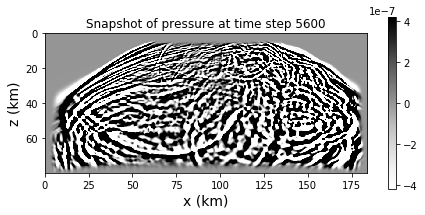

it/nt = 5700/20000


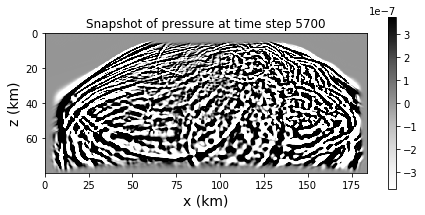

it/nt = 5800/20000


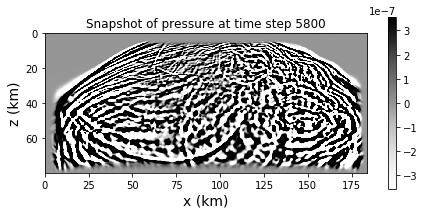

it/nt = 5900/20000


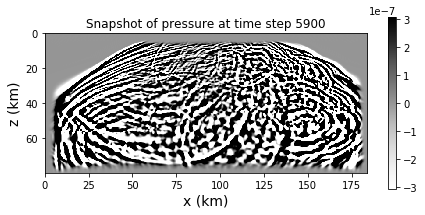

it/nt = 6000/20000


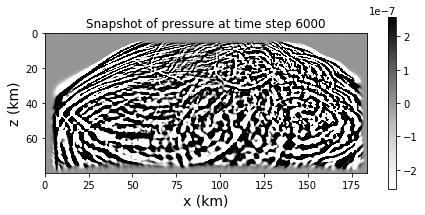

it/nt = 6100/20000


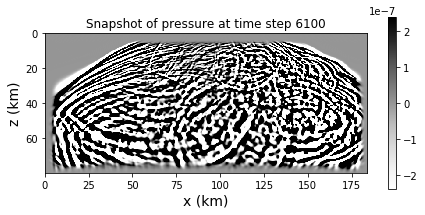

it/nt = 6200/20000


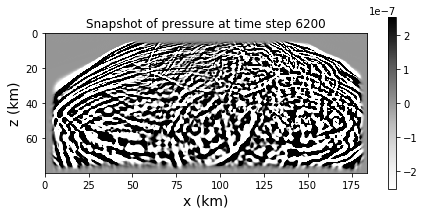

it/nt = 6300/20000


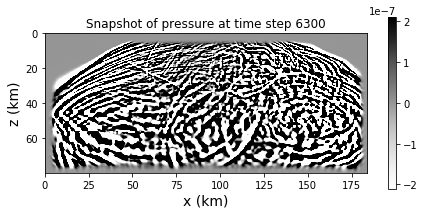

it/nt = 6400/20000


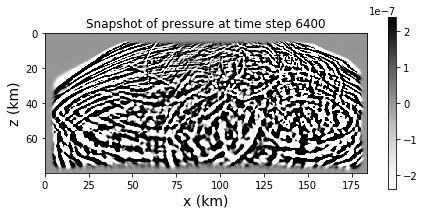

it/nt = 6500/20000


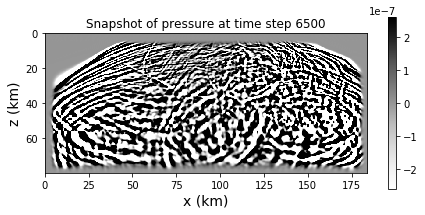

it/nt = 6600/20000


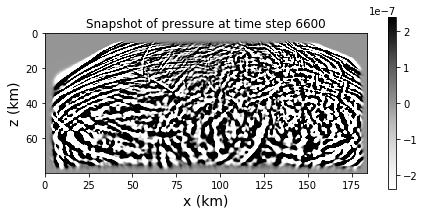

it/nt = 6700/20000


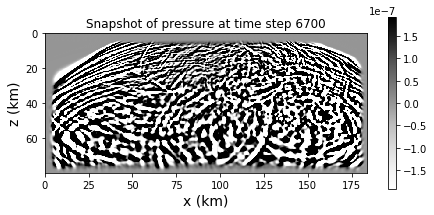

it/nt = 6800/20000


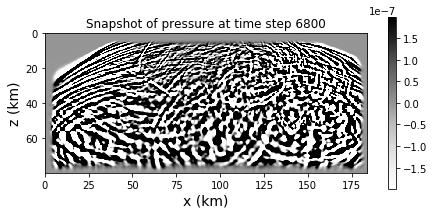

it/nt = 6900/20000


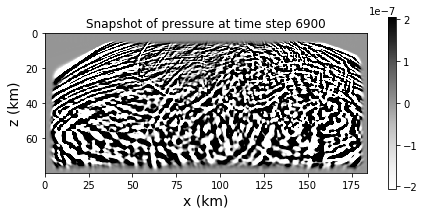

it/nt = 7000/20000


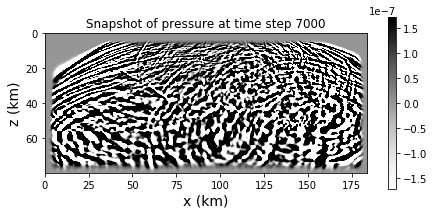

it/nt = 7100/20000


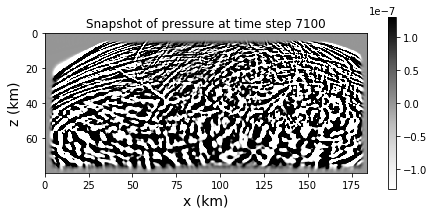

it/nt = 7200/20000


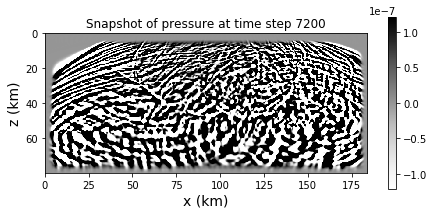

it/nt = 7300/20000


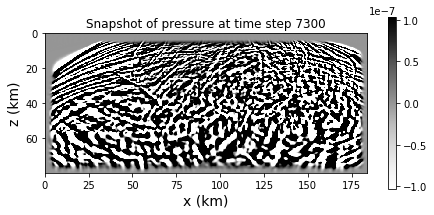

it/nt = 7400/20000


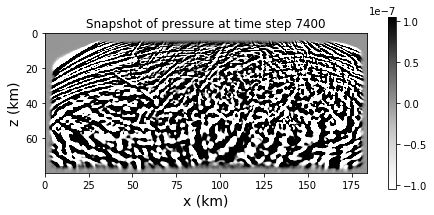

it/nt = 7500/20000


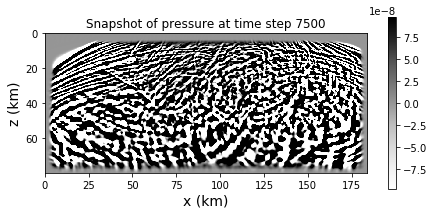

it/nt = 7600/20000


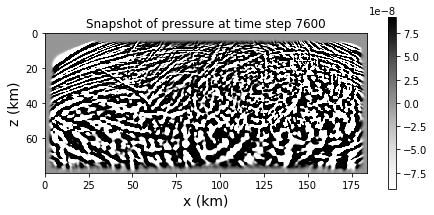

it/nt = 7700/20000


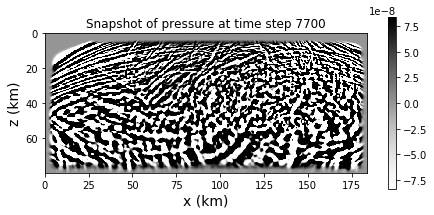

it/nt = 7800/20000


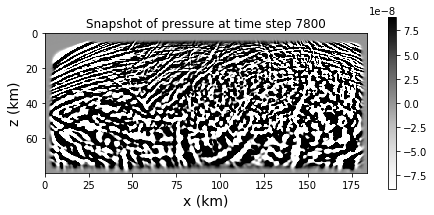

it/nt = 7900/20000


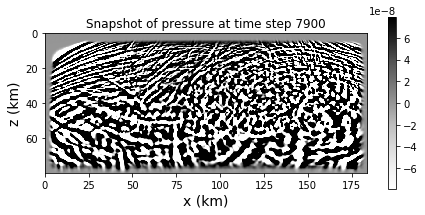

it/nt = 8000/20000


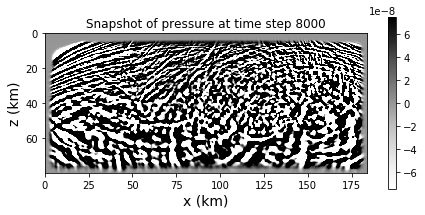

it/nt = 8100/20000


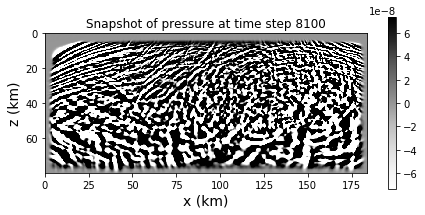

it/nt = 8200/20000


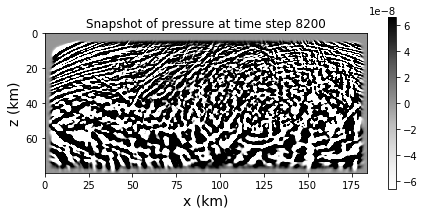

it/nt = 8300/20000


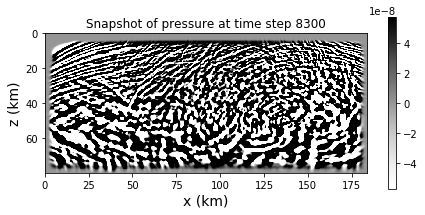

it/nt = 8400/20000


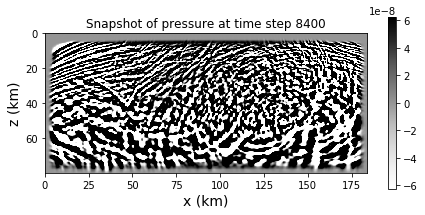

it/nt = 8500/20000


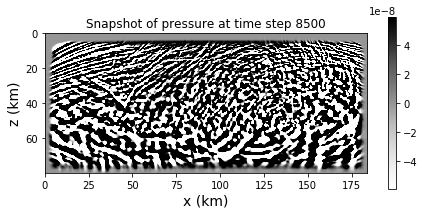

it/nt = 8600/20000


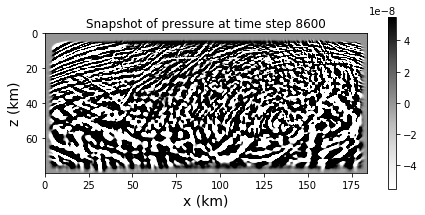

it/nt = 8700/20000


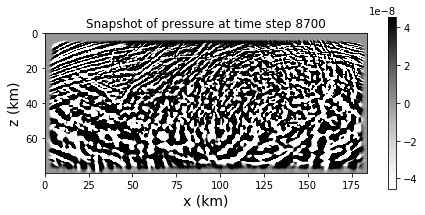

it/nt = 8800/20000


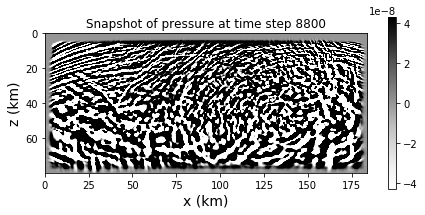

it/nt = 8900/20000


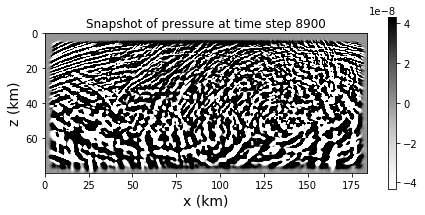

it/nt = 9000/20000


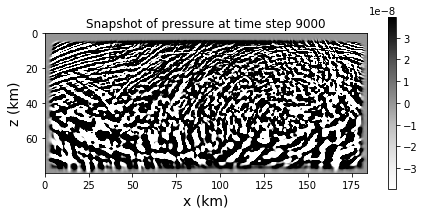

it/nt = 9100/20000


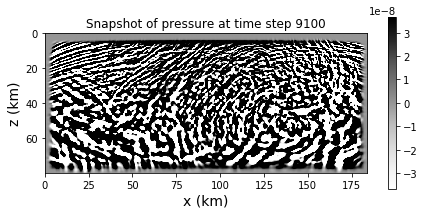

it/nt = 9200/20000


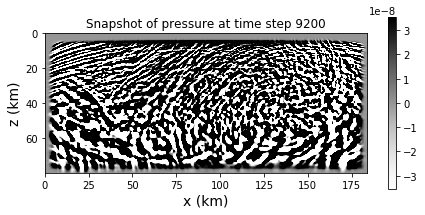

it/nt = 9300/20000


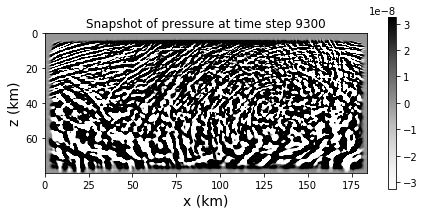

it/nt = 9400/20000


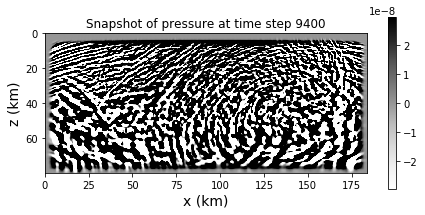

it/nt = 9500/20000


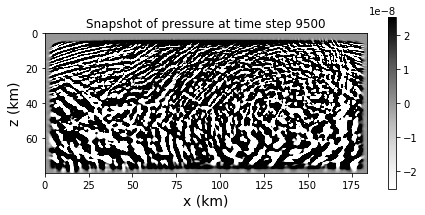

it/nt = 9600/20000


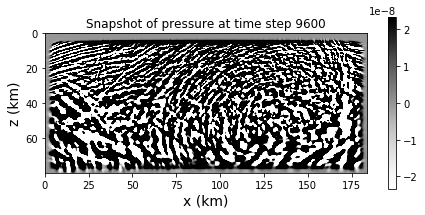

it/nt = 9700/20000


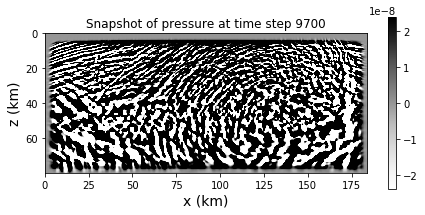

it/nt = 9800/20000


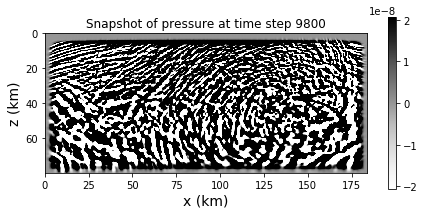

it/nt = 9900/20000


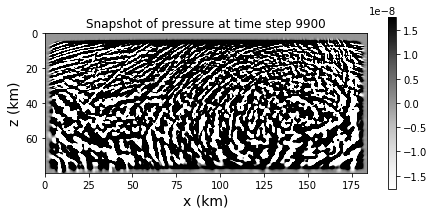

it/nt = 10000/20000


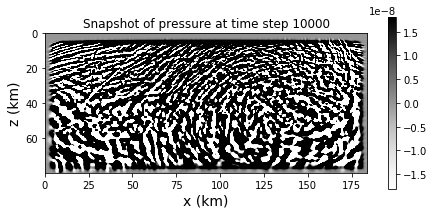

it/nt = 10100/20000


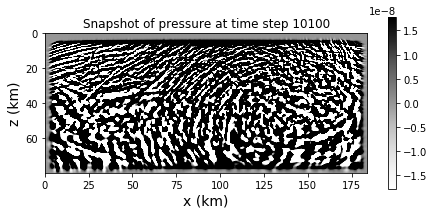

it/nt = 10200/20000


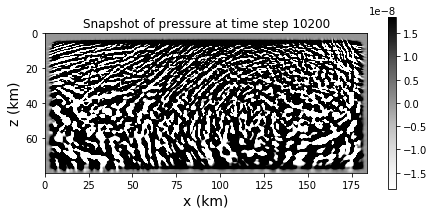

it/nt = 10300/20000


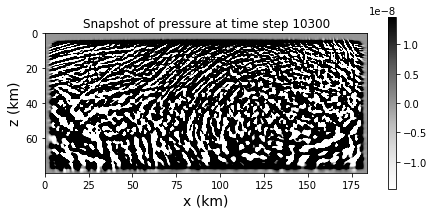

it/nt = 10400/20000


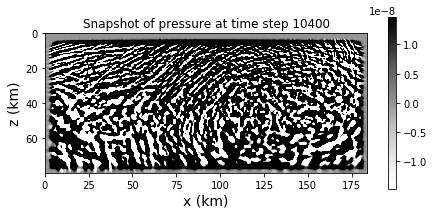

it/nt = 10500/20000


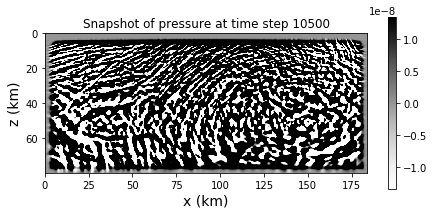

it/nt = 10600/20000


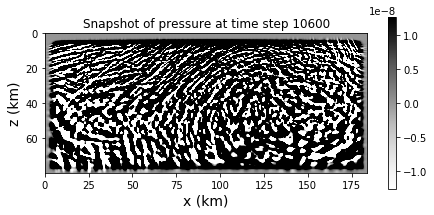

it/nt = 10700/20000


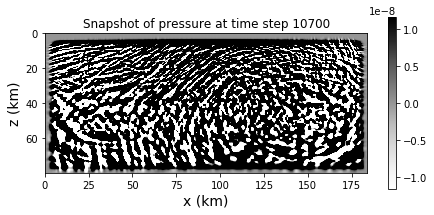

it/nt = 10800/20000


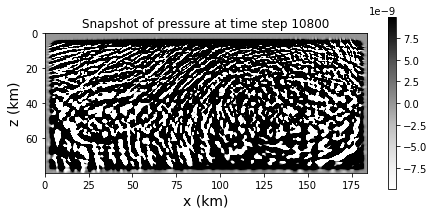

it/nt = 10900/20000


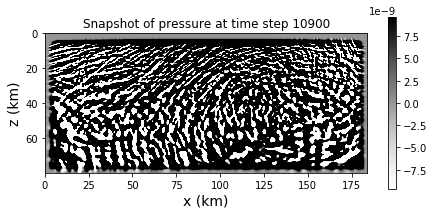

it/nt = 11000/20000


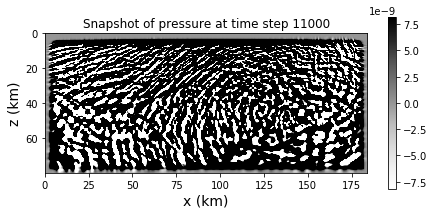

it/nt = 11100/20000


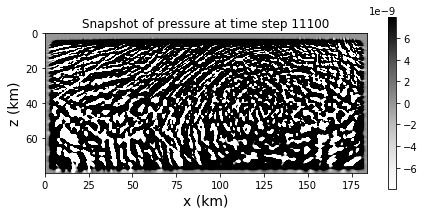

it/nt = 11200/20000


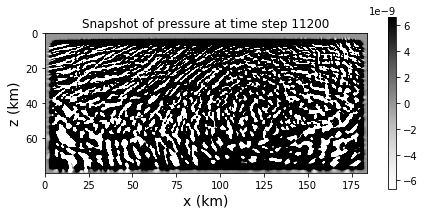

it/nt = 11300/20000


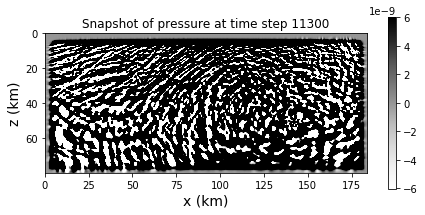

it/nt = 11400/20000


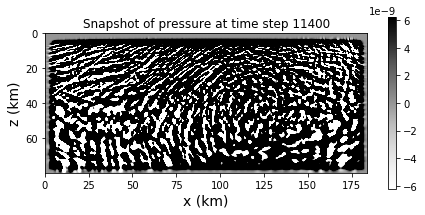

it/nt = 11500/20000


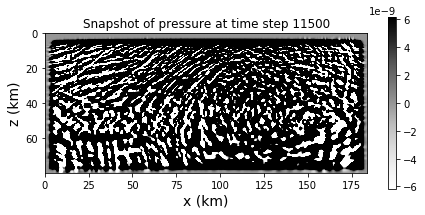

it/nt = 11600/20000


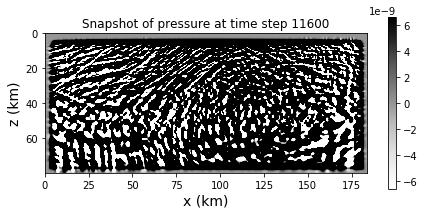

it/nt = 11700/20000


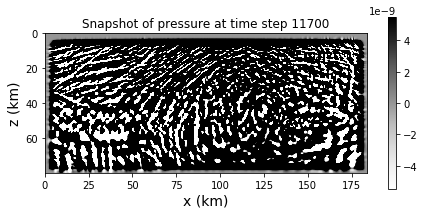

it/nt = 11800/20000


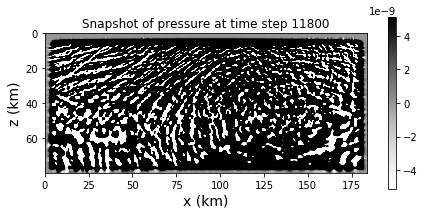

it/nt = 11900/20000


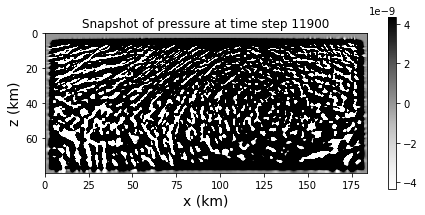

it/nt = 12000/20000


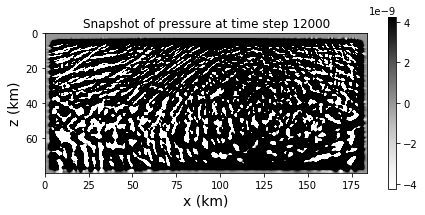

it/nt = 12100/20000


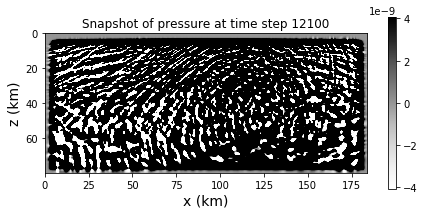

it/nt = 12200/20000


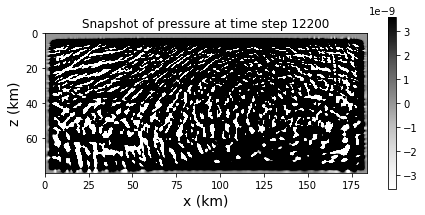

it/nt = 12300/20000


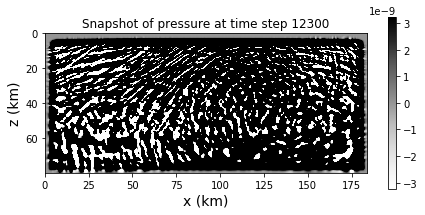

it/nt = 12400/20000


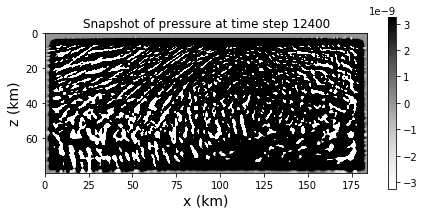

it/nt = 12500/20000


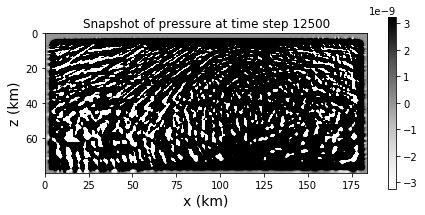

it/nt = 12600/20000


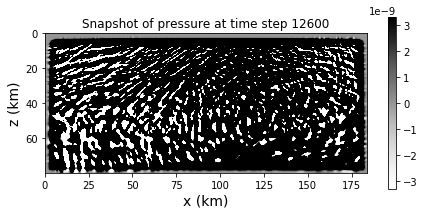

it/nt = 12700/20000


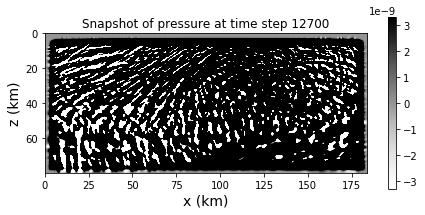

it/nt = 12800/20000


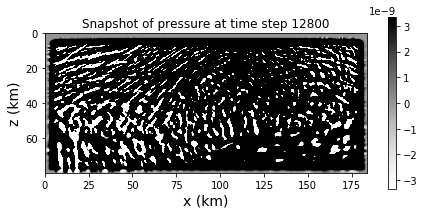

it/nt = 12900/20000


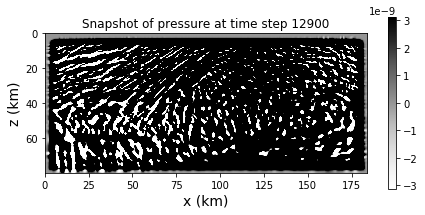

it/nt = 13000/20000


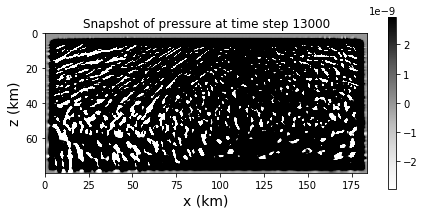

it/nt = 13100/20000


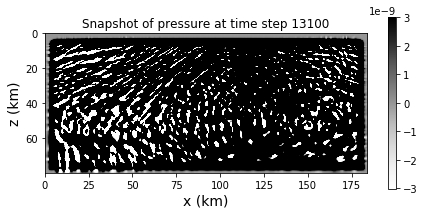

it/nt = 13200/20000


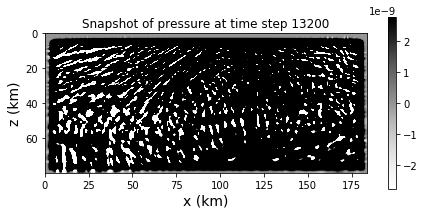

it/nt = 13300/20000


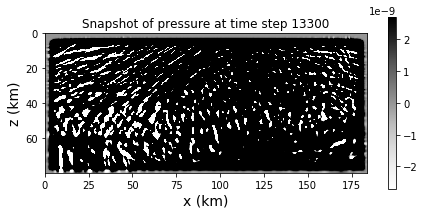

it/nt = 13400/20000


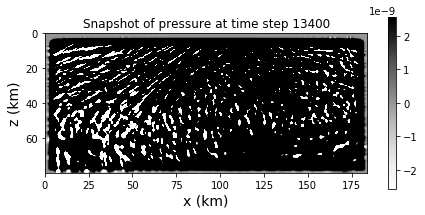

it/nt = 13500/20000


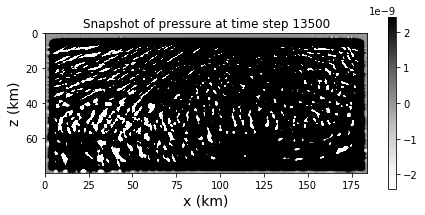

it/nt = 13600/20000


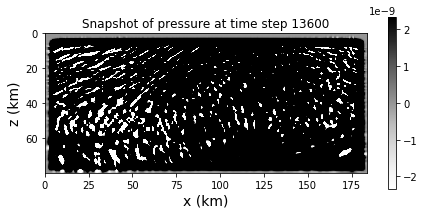

it/nt = 13700/20000


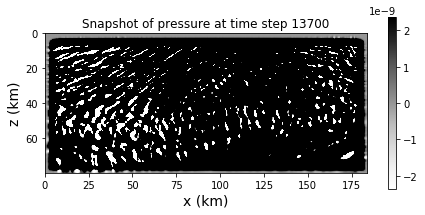

it/nt = 13800/20000


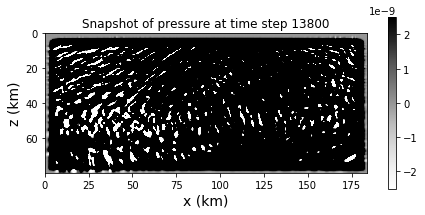

it/nt = 13900/20000


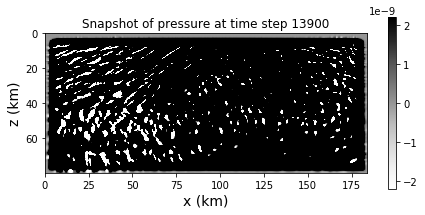

it/nt = 14000/20000


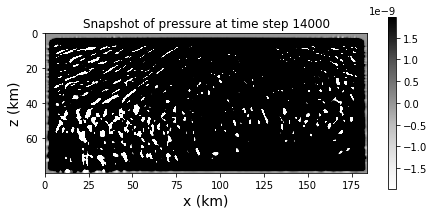

it/nt = 14100/20000


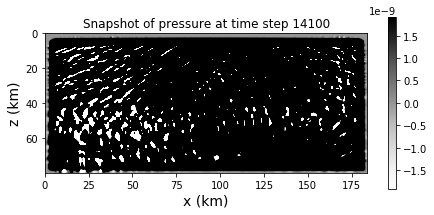

it/nt = 14200/20000


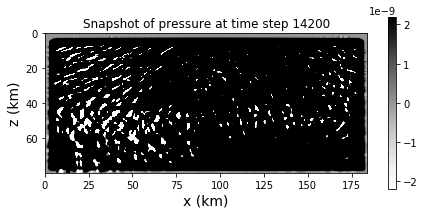

it/nt = 14300/20000


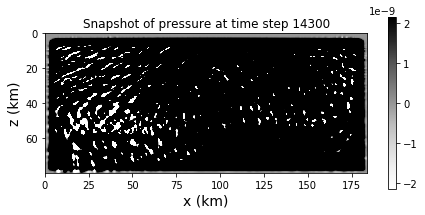

it/nt = 14400/20000


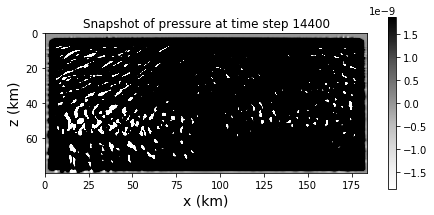

it/nt = 14500/20000


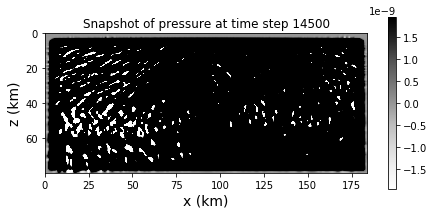

it/nt = 14600/20000


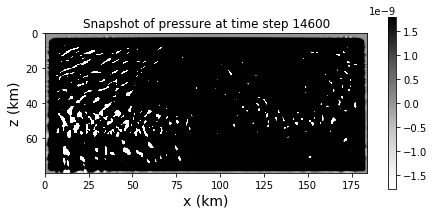

it/nt = 14700/20000


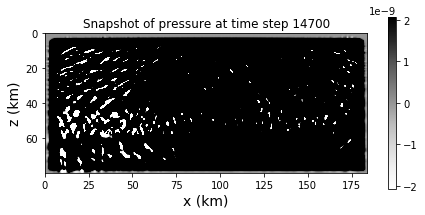

it/nt = 14800/20000


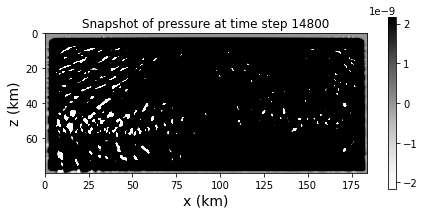

it/nt = 14900/20000


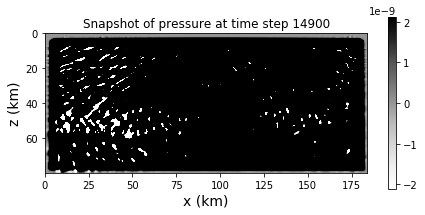

it/nt = 15000/20000


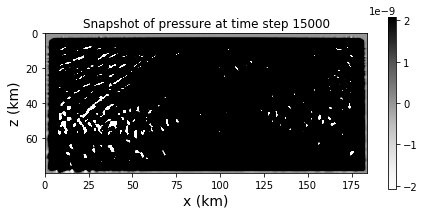

it/nt = 15100/20000


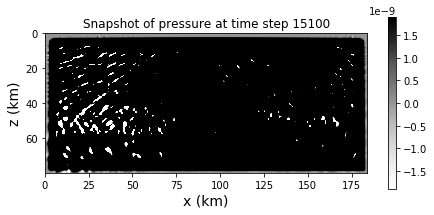

it/nt = 15200/20000


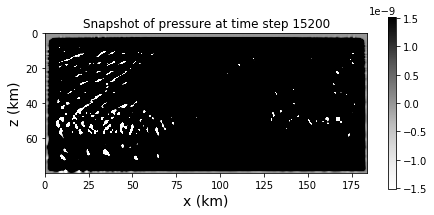

it/nt = 15300/20000


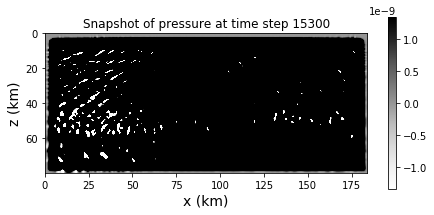

it/nt = 15400/20000


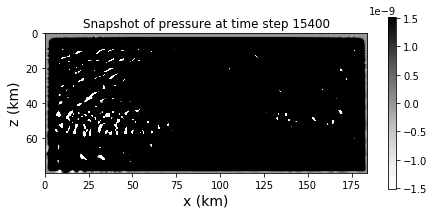

it/nt = 15500/20000


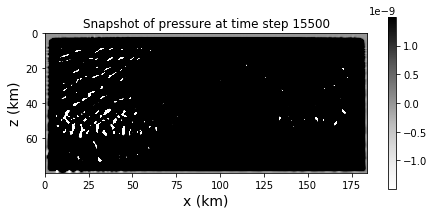

it/nt = 15600/20000


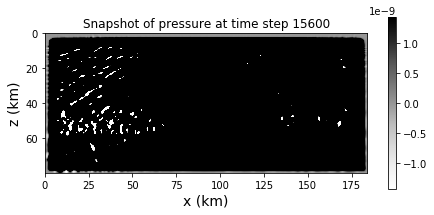

it/nt = 15700/20000


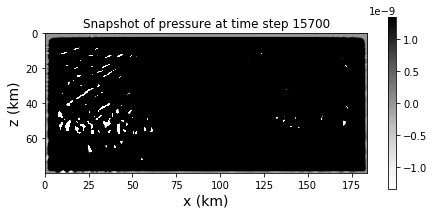

it/nt = 15800/20000


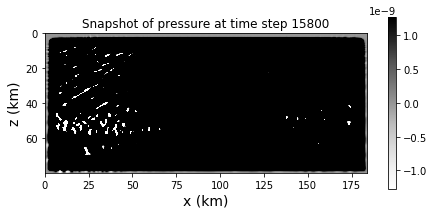

it/nt = 15900/20000


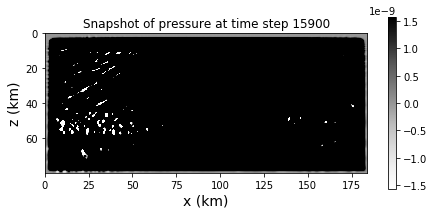

it/nt = 16000/20000


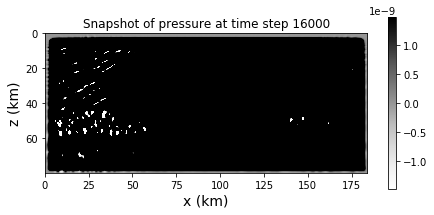

it/nt = 16100/20000


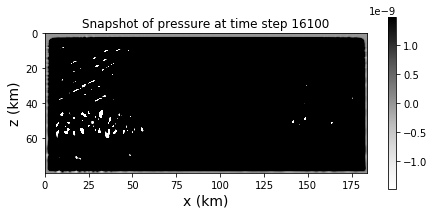

it/nt = 16200/20000


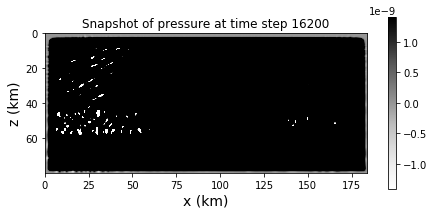

it/nt = 16300/20000


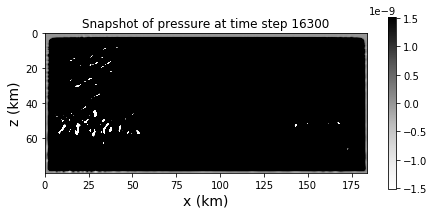

it/nt = 16400/20000


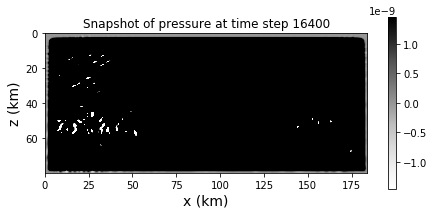

it/nt = 16500/20000


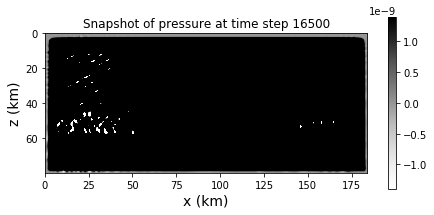

it/nt = 16600/20000


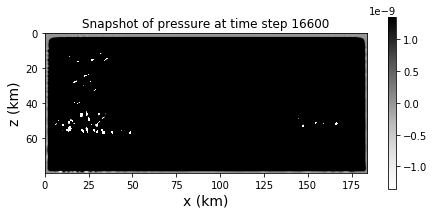

it/nt = 16700/20000


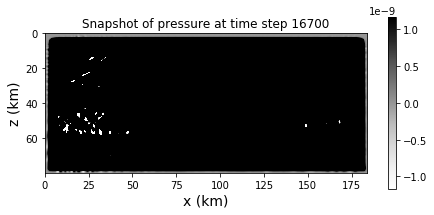

it/nt = 16800/20000


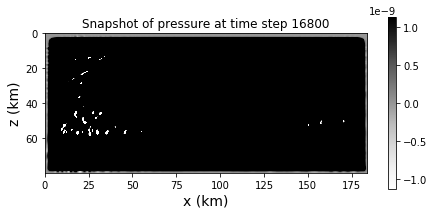

it/nt = 16900/20000


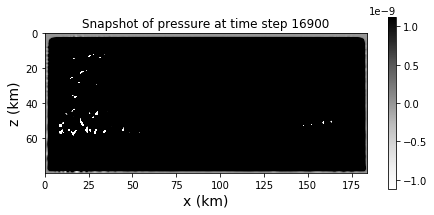

it/nt = 17000/20000


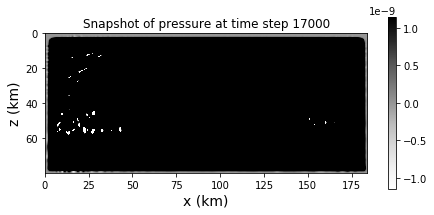

it/nt = 17100/20000


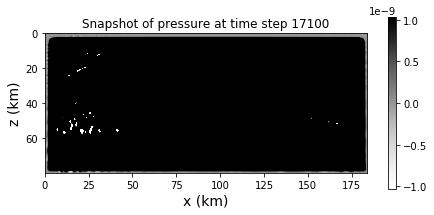

it/nt = 17200/20000


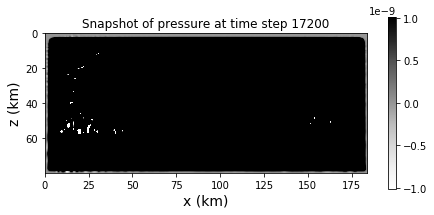

it/nt = 17300/20000


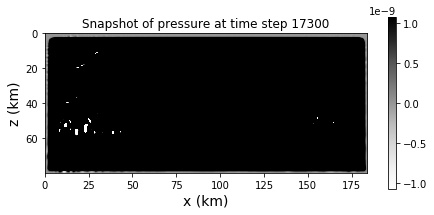

it/nt = 17400/20000


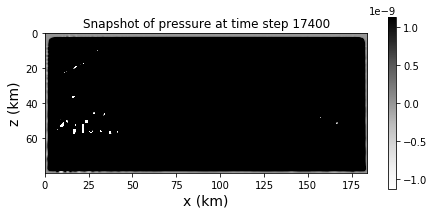

it/nt = 17500/20000


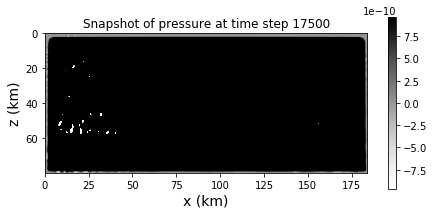

it/nt = 17600/20000


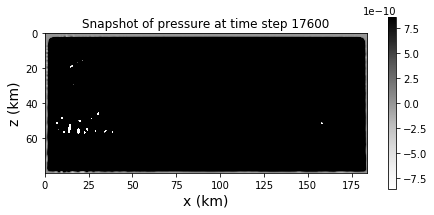

it/nt = 17700/20000


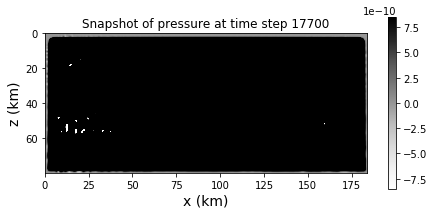

it/nt = 17800/20000


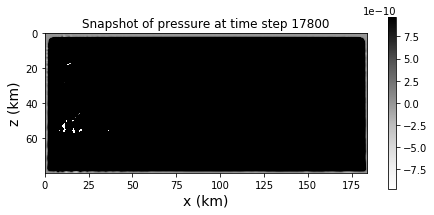

it/nt = 17900/20000


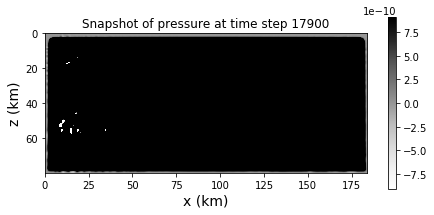

it/nt = 18000/20000


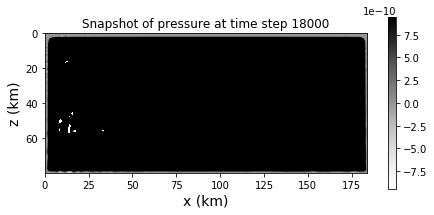

it/nt = 18100/20000


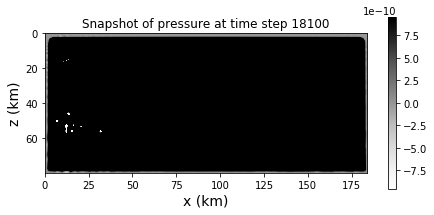

it/nt = 18200/20000


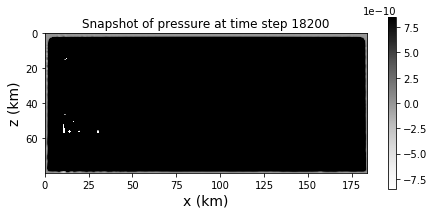

it/nt = 18300/20000


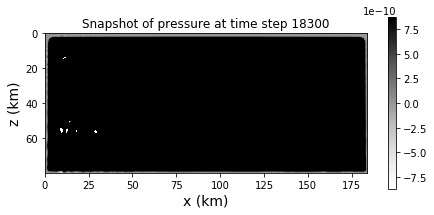

it/nt = 18400/20000


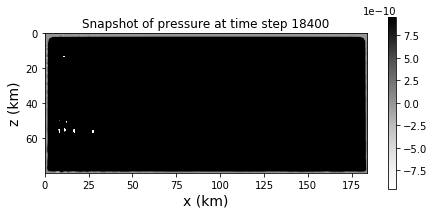

it/nt = 18500/20000


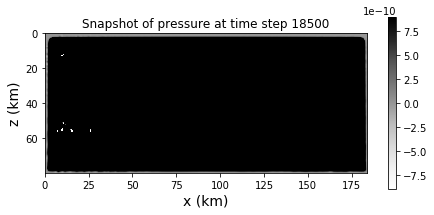

it/nt = 18600/20000


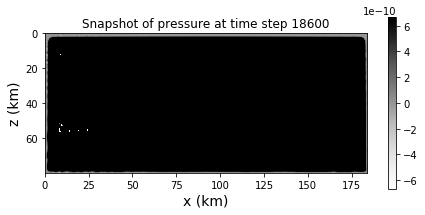

it/nt = 18700/20000


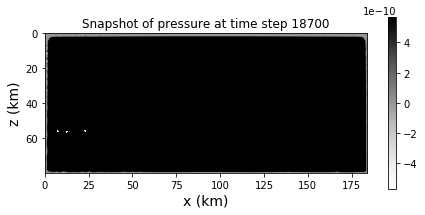

it/nt = 18800/20000


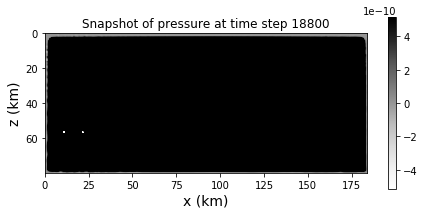

it/nt = 18900/20000


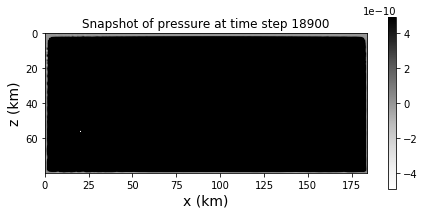

it/nt = 19000/20000


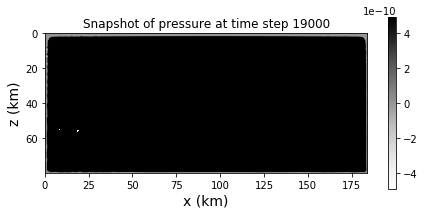

it/nt = 19100/20000


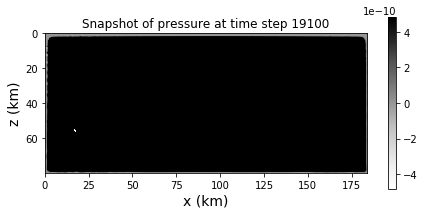

it/nt = 19200/20000


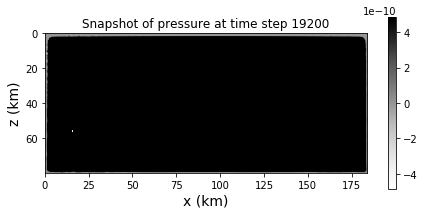

it/nt = 19300/20000


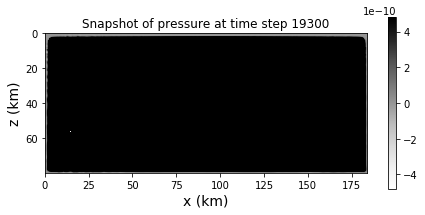

it/nt = 19400/20000


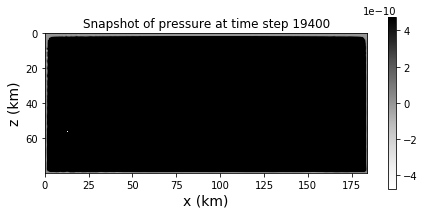

it/nt = 19500/20000


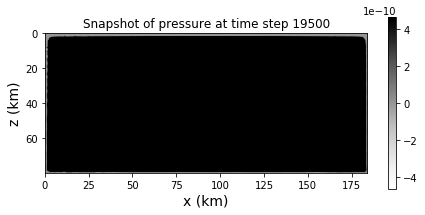

it/nt = 19600/20000


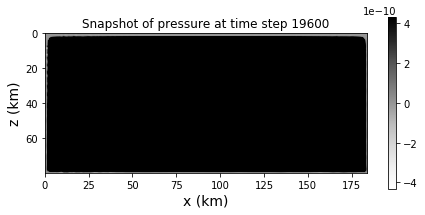

it/nt = 19700/20000


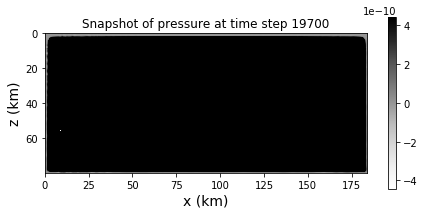

it/nt = 19800/20000


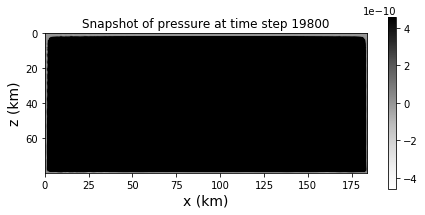

it/nt = 19900/20000


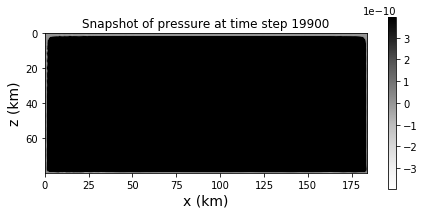

it/nt = 19999/20000


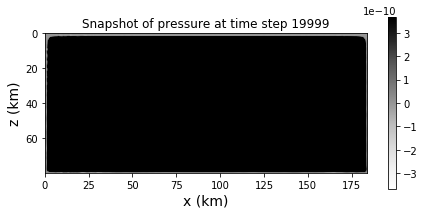

FD modeling runtime: 4197.083975553513 s


In [25]:
### count the total number of time sampling in the output seismogram file
nt_fout = 0

### start FD modeling
time_start = tm.time()

### time evolution of the wavefield
for it in range(nt):   
    ### dPdx, dPdz at (ix+1/2, iz+1/2) --------
    rgt1 = np.roll(p, -1, axis=1)
    lft1 = np.roll(p,  1, axis=1)
    
    dwn1 = np.roll(p, -1, axis=0)
    upp1 = np.roll(p,  1, axis=0)
    
    rgt2 = np.roll(p, -2, axis=1)
    lft2 = np.roll(p,  2, axis=1)
    
    dwn2 = np.roll(p, -2, axis=0)
    upp2 = np.roll(p,  2, axis=0)    
    
    rgt3 = np.roll(p, -3, axis=1)
    lft3 = np.roll(p,  3, axis=1)
    
    dwn3 = np.roll(p, -3, axis=0)
    upp3 = np.roll(p,  3, axis=0)    
    
    rgt4 = np.roll(p, -4, axis=1)
    lft4 = np.roll(p,  4, axis=1)
    
    dwn4 = np.roll(p, -4, axis=0)
    upp4 = np.roll(p,  4, axis=0) 
    
    rgt5 = np.roll(p, -5, axis=1)
    lft5 = np.roll(p,  5, axis=1)
    
    dwn5 = np.roll(p, -5, axis=0)
    upp5 = np.roll(p,  5, axis=0)

    rgt6 = np.roll(p, -6, axis=1)
    lft6 = np.roll(p,  6, axis=1)
    
    dwn6 = np.roll(p, -6, axis=0)
    upp6 = np.roll(p,  6, axis=0) 
    
    rgt7 = np.roll(p, -7, axis=1)
    
    dwn7 = np.roll(p, -7, axis=0)
   
    
    dpdx = (cn[0]*(rgt1-p) + cn[1]*(rgt2-lft1) + cn[2]*(rgt3-lft2) + cn[3]*(rgt4-lft3) \
          + cn[4]*(rgt5-lft4) + cn[5]*(rgt6-lft5) + cn[6]*(rgt7-lft6)) / dx 
    
    dpdz = (cn[0]*(dwn1-p) + cn[1]*(dwn2-upp1) + cn[2]*(dwn3-upp2) + cn[3]*(dwn4-upp3) \
          + cn[4]*(dwn5-upp4) + cn[5]*(dwn6-upp5) + cn[6]*(dwn7-upp6)) / dz
    
            
    S_x = xi_x_hlf*dpdx - phi_x_hlf*Omega_x
    
    S_z = xi_z_hlf*dpdz - phi_z_hlf*Omega_z
    
    
    Omega_x += lambda_x_hlf*S_x - alpha_x_hlf*dpdx
    
    Omega_z += lambda_z_hlf*S_z - alpha_z_hlf*dpdz

    
    
    ### dPdxx, dPdzz at (ix, iz) --------
    rgt1 = np.roll(S_x, -1, axis=1)
    lft1 = np.roll(S_x,  1, axis=1)
    
    dwn1 = np.roll(S_z, -1, axis=0)
    upp1 = np.roll(S_z,  1, axis=0)
    
    rgt2 = np.roll(S_x, -2, axis=1)
    lft2 = np.roll(S_x,  2, axis=1)
    
    dwn2 = np.roll(S_z, -2, axis=0)
    upp2 = np.roll(S_z,  2, axis=0)    
    
    rgt3 = np.roll(S_x, -3, axis=1)
    lft3 = np.roll(S_x,  3, axis=1)
    
    dwn3 = np.roll(S_z, -3, axis=0)
    upp3 = np.roll(S_z,  3, axis=0)    
    
    rgt4 = np.roll(S_x, -4, axis=1)
    lft4 = np.roll(S_x,  4, axis=1)
    
    dwn4 = np.roll(S_z, -4, axis=0)
    upp4 = np.roll(S_z,  4, axis=0) 
    
    rgt5 = np.roll(S_x, -5, axis=1)
    lft5 = np.roll(S_x,  5, axis=1)
    
    dwn5 = np.roll(S_z, -5, axis=0)
    upp5 = np.roll(S_z,  5, axis=0)

    rgt6 = np.roll(S_x, -6, axis=1)
    lft6 = np.roll(S_x,  6, axis=1)
    
    dwn6 = np.roll(S_z, -6, axis=0)
    upp6 = np.roll(S_z,  6, axis=0)
    
    lft7 = np.roll(S_x, -7, axis=1)
    
    upp7 = np.roll(S_z, -7, axis=0)
        
    
    dpdxx = (cn[0]*(S_x-lft1) + cn[1]*(rgt1-lft2) + cn[2]*(rgt2-lft3) + cn[3]*(rgt3-lft4) \
          + cn[4]*(rgt4-lft5) + cn[5]*(rgt5-lft6) + cn[6]*(rgt6-lft7)) / dx
    
    dpdzz = (cn[0]*(S_z-upp1) + cn[1]*(dwn1-upp2) + cn[2]*(dwn2-upp3) + cn[3]*(dwn3-upp4) \
          + cn[4]*(dwn4-upp5) + cn[5]*(dwn5-upp6) + cn[6]*(dwn6-upp7)) / dz
    
                    
    S_xx = xi_x*dpdxx - phi_x*Omega_xx
    
    S_zz = xi_z*dpdzz - phi_z*Omega_zz   
    
    
    Omega_xx += lambda_x*S_xx - alpha_x*dpdxx
    
    Omega_zz += lambda_z*S_zz - alpha_z*dpdzz
    
    
    ### laplacian = dpdxx + dpdzz -----------
    laplace = S_xx + S_zz
    
##################################################################    
    ### ----------- 5th-order  ------------------------------
    ### RHS of the equations for memory variables 
    RHSe = Ae_array * laplace
    
    ### update wx=wx(t=it+1/2)   
    re0_new = weight1[0]*re0_old + dt*weight2[0]*sl[0]*RHSe
    re1_new = weight1[1]*re1_old + dt*weight2[1]*sl[1]*RHSe
    re2_new = weight1[2]*re2_old + dt*weight2[2]*sl[2]*RHSe
    re3_new = weight1[3]*re3_old + dt*weight2[3]*sl[3]*RHSe
    re4_new = weight1[4]*re4_old + dt*weight2[4]*sl[4]*RHSe  
    
    ### the average: re(t=it) = 0.5*(re(t=it+1/2) + re(t=it-1/2))
    re0_avg = 0.5*(re0_new + re0_old)
    re1_avg = 0.5*(re1_new + re1_old)
    re2_avg = 0.5*(re2_new + re2_old)
    re3_avg = 0.5*(re3_new + re3_old)
    re4_avg = 0.5*(re4_new + re4_old)
    
    ### re sums over the element index
    re_sum = re0_avg + re1_avg + re2_avg + re3_avg + re4_avg
    
    ### ----------- 4th-order  ------------------------------
    ### RHS of the equations for memory variables 
    RHSd = Ad_array * laplace - re_sum
    
    ### update wx=wx(t=it+1/2)   
    rd0_new = weight1[0]*rd0_old + dt*weight2[0]*sl[0]*RHSd
    rd1_new = weight1[1]*rd1_old + dt*weight2[1]*sl[1]*RHSd
    rd2_new = weight1[2]*rd2_old + dt*weight2[2]*sl[2]*RHSd
    rd3_new = weight1[3]*rd3_old + dt*weight2[3]*sl[3]*RHSd
    rd4_new = weight1[4]*rd4_old + dt*weight2[4]*sl[4]*RHSd  
    
    ### the average: rd(t=it) = 0.5*(rd(t=it+1/2) + rd(t=it-1/2))
    rd0_avg = 0.5*(rd0_new + rd0_old)
    rd1_avg = 0.5*(rd1_new + rd1_old)
    rd2_avg = 0.5*(rd2_new + rd2_old)
    rd3_avg = 0.5*(rd3_new + rd3_old)
    rd4_avg = 0.5*(rd4_new + rd4_old)
    
    ### rd sums over the element index
    rd_sum = rd0_avg + rd1_avg + rd2_avg + rd3_avg + rd4_avg    

    ### ----------- 3rd-order  ------------------------------
    ### RHS of the equations for memory variables 
    RHSc = Ac_array * laplace - rd_sum
    
    ### update wx=wx(t=it+1/2)   
    rc0_new = weight1[0]*rc0_old + dt*weight2[0]*sl[0]*RHSc
    rc1_new = weight1[1]*rc1_old + dt*weight2[1]*sl[1]*RHSc
    rc2_new = weight1[2]*rc2_old + dt*weight2[2]*sl[2]*RHSc
    rc3_new = weight1[3]*rc3_old + dt*weight2[3]*sl[3]*RHSc
    rc4_new = weight1[4]*rc4_old + dt*weight2[4]*sl[4]*RHSc  
    
    ### the average: rc(t=it) = 0.5*(rc(t=it+1/2) + rc(t=it-1/2))
    rc0_avg = 0.5*(rc0_new + rc0_old)
    rc1_avg = 0.5*(rc1_new + rc1_old)
    rc2_avg = 0.5*(rc2_new + rc2_old)
    rc3_avg = 0.5*(rc3_new + rc3_old)
    rc4_avg = 0.5*(rc4_new + rc4_old)
    
    ### re sums over the element index
    rc_sum = rc0_avg + rc1_avg + rc2_avg + rc3_avg + rc4_avg    

    ### ----------- 2nd-order  ------------------------------
    ### RHS of the equations for memory variables 
    RHSb = Ab_array * laplace - rc_sum
    
    ### update wx=wx(t=it+1/2)   
    rb0_new = weight1[0]*rb0_old + dt*weight2[0]*sl[0]*RHSb
    rb1_new = weight1[1]*rb1_old + dt*weight2[1]*sl[1]*RHSb
    rb2_new = weight1[2]*rb2_old + dt*weight2[2]*sl[2]*RHSb
    rb3_new = weight1[3]*rb3_old + dt*weight2[3]*sl[3]*RHSb
    rb4_new = weight1[4]*rb4_old + dt*weight2[4]*sl[4]*RHSb  
    
    ### the average: re(t=it) = 0.5*(re(t=it+1/2) + re(t=it-1/2))
    rb0_avg = 0.5*(rb0_new + rb0_old)
    rb1_avg = 0.5*(rb1_new + rb1_old)
    rb2_avg = 0.5*(rb2_new + rb2_old)
    rb3_avg = 0.5*(rb3_new + rb3_old)
    rb4_avg = 0.5*(rb4_new + rb4_old)
    
    ### re sums over the element index
    rb_sum = rb0_avg + rb1_avg + rb2_avg + rb3_avg + rb4_avg
    
    ### ----------- 1st-order  ------------------------------
    ### RHS of the equations for memory variables 
    RHSa = Aa_array * laplace - rb_sum
    
    ### update wx=wx(t=it+1/2)   
    ra0_new = weight1[0]*ra0_old + dt*weight2[0]*sl[0]*RHSa
    ra1_new = weight1[1]*ra1_old + dt*weight2[1]*sl[1]*RHSa
    ra2_new = weight1[2]*ra2_old + dt*weight2[2]*sl[2]*RHSa
    ra3_new = weight1[3]*ra3_old + dt*weight2[3]*sl[3]*RHSa
    ra4_new = weight1[4]*ra4_old + dt*weight2[4]*sl[4]*RHSa  
    
    ### the average: re(t=it) = 0.5*(re(t=it+1/2) + re(t=it-1/2))
    ra0_avg = 0.5*(ra0_new + ra0_old)
    ra1_avg = 0.5*(ra1_new + ra1_old)
    ra2_avg = 0.5*(ra2_new + ra2_old)
    ra3_avg = 0.5*(ra3_new + ra3_old)
    ra4_avg = 0.5*(ra4_new + ra4_old)
    
    ### re sums over the element index
    ra_sum = ra0_avg + ra1_avg + ra2_avg + ra3_avg + ra4_avg    
    
        
    ##### calculate RHS of the 2nd-order equation at time t=it
    RHS = A0_array * laplace - ra_sum
    
    ### calculate pnew=p(t=it+1) --------------   
    pnew = 2.*p - pold  +  (dt**2)*RHS
                     
    ### Add Source Term at [jsrc, isrc].
    ### The Dirac delta is approximated by 1/dx and 1/dz along x- and z- directions, respectively.
    pnew[jsrc,isrc] += src[it] * (dt**2) / (dx*dz)     

    ### update the wavefield and memory variables
    ### update the wavefield 
    pold = p
    p    = pnew 
    
    ### update the memory variables
    re0_old = re0_new
    re1_old = re1_new
    re2_old = re2_new
    re3_old = re3_new
    re4_old = re4_new
    
    rd0_old = rd0_new
    rd1_old = rd1_new
    rd2_old = rd2_new
    rd3_old = rd3_new
    rd4_old = rd4_new
    
    rc0_old = rc0_new
    rc1_old = rc1_new
    rc2_old = rc2_new
    rc3_old = rc3_new
    rc4_old = rc4_new
    
    rb0_old = rb0_new
    rb1_old = rb1_new
    rb2_old = rb2_new
    rb3_old = rb3_new
    rb4_old = rb4_new    
    
    ra0_old = ra0_new
    ra1_old = ra1_new
    ra2_old = ra2_new
    ra3_old = ra3_new
    ra4_old = ra4_new    
    
    ### Output of Seismogram
    ### -----------------
    if (it % it_fout == 0) :
        seis_all[nt_fout, :] = pnew[jr, :]
        nt_fout += 1
    
    ### snapshot 
    if it % it_snapshot == 0 or it == (nt-1):
        print('it/nt = ' + str(it)+'/'+str(nt))
        plot_snapshot("Snapshot of pressure at time step "+str(it),"p_%06d" %(it), pnew, \
                      nz, nx, dz, dx, 'z (km)', 'x (km)', clip=0.01, color="Greys")
        
## stop FD modeling
time_end = tm.time()
print('FD modeling runtime:', (time_end - time_start), 's')

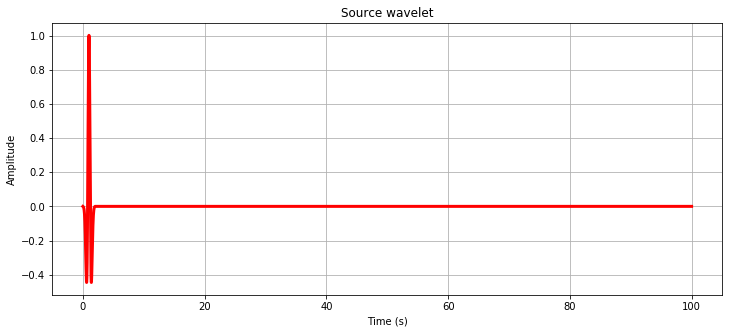

In [26]:
### plot source wavelet
# ---------------------------------------------- 
fig = plt.figure(figsize=(12, 5))
Analy_seis = plt.plot(time, src, color='r', lw=3, ls='solid') # plot analytical solution
plt.title('Source wavelet')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()

plt.show()  
plt.close()

In [27]:
#### save seismogram to npy-format file
fout = './out/seism_iQflag_' + str(int(iQflag)) + '_5thOrder.npy'
np.save(fout, seis_all)

In [28]:
#### save pars to file
fout = './out/outpars_iQflag_' + str(int(iQflag)) + '_5thOrder.txt'
f = open(fout,'w+')
f.write('nx = ' + str(nx))
f.write('\n\n')
f.write('nz = ' + str(nz))
f.write('\n\n')
f.write('nt = ' + str(nt))
f.write('\n\n')
f.write('dt = ' + str(dt))
f.write('\n\n')
f.write('\n\n')
f.write('\n\n')
f.write('nt_fout = ' + str(nt_fout))
f.write('\n\n')
f.write('dt_fout = ' + str(dt_fout))
f.write('\n\n')
f.write('f0 = ' + str(f0))
f.write('\n\n')
f.write('iQflag = ' + str(iQflag))
f.write('\n\n')
f.write('n_absorb = ' + str(n_absorb))
f.write('\n\n\n')
f.write('kappa_max = ' + str(kappa_max))
f.write('\n\n')
f.write('alpha_max = ' + str(alpha_max))
f.write('\n\n')
f.write('Rcmax = ' + str(Rcmax))
f.write('\n\n')
f.write('vPMLmax = ' + str(vPMLmax))
f.write('\n\n\n\n')
f.write('isrc = ' + str(isrc))
f.write('\n\n')
f.write('jsrc = ' + str(jsrc))
f.write('\n\n')
f.write('jr = ' + str(jr))
f.write('\n\n')
f.write('time_cost = ' + str(time_end - time_start))
f.close()